In [2]:
import warnings
warnings.filterwarnings('ignore')

# Imbalanced Classification Techniques for Predicting whether a Pokemon is Legendary or not


# 1. Problem Definition

Given basic statistics of Pokemon, can we predict if a Pokemon is legendary?


# 2. Data 

The main dataset we are using can be found on [Kaggle](https://www.kaggle.com/abcsds/pokemon). The other part of the data is gathered with web crawling technique used on the following web site https://pokemondb.net/.

# 3. Features

Each row in the dataset presents different Pokemon, each described with 13 attributes:
1. \# - ID of Pokemon.
2. Name - Name of Pokemon.
3. Type 1 - Primary type of Pokemon.
    * Possible values for Type 1: 'Normal', 'Fire', 'Water', 'Electric', 'Grass', 'Ice', 'Fighting', 'Poison', 'Ground', 'Flying', 'Psychic', 'Bug', 'Rock', 'Ghost', 'Dragon', 'Dark', 'Steel', 'Fairy'.
4. Type 2 - Secondary type of Pokemon. Some Pokemon are dual type.
    * Possible values for Type 2: 'Normal', 'Fire', 'Water', 'Electric', 'Grass', 'Ice', 'Fighting', 'Poison', 'Ground', 'Flying', 'Psychic', 'Bug', 'Rock', 'Ghost', 'Dragon', 'Dark', 'Steel', 'Fairy', '' (empty string) - Pokemon is not dual type.
5. Total - Sum of all Pokemon's statistics (HP, Attack, Defense, Sp. Atk, Sp. Def, Speed).  
6. HP (Hit Points) - Pokemon's life force.
7. Attack - Measure the strength of moves used by Pokemon for normal attack.
8. Defense - Measure the ability to take normal attacks from other Pokemon.
9. Sp. Atk (Special Attack) - Measure the strength of moves used by Pokemon for special attack.
10. Sp. Def (Special Defense) - Measure the ability to take special attacks from other Pokemon.
11. Speed - Pokemon Speed.
12. Generation - From which generation is the Pokemon.
    * Number (1-8).
13. Legendary - Is Pokemon legendary or not. Legendary Pokemon is Pokemon with strong statistics.
    * True - Pokemon is legendary.
    * False - Pokemon is not legendary.

# 4. Preparing the Tools

We are going to use multiple Python libraries as pandas, NumPy, Matplotlib, scikit-learn,..


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import cv2
import time
import csv
import scrapy

# We want our plots to appear in the notebook
%matplotlib inline 

# Scaler
from sklearn.preprocessing import MinMaxScaler

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from collections import Counter
from imblearn.over_sampling import SMOTE 

# Model evaluators
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report,plot_roc_curve,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,auc

from sklearn.tree import export_graphviz

# 5. Load data

In the original dataset from Kaggle, Pokemons from 7th and 8th generation were missing. To make the data complete, we made a crawler and used it to find the missing Pokemon.

In [4]:
# Crawler
# %load Data_Gathering_Attributes.py

class PokeSpider(scrapy.Spider):
    name='pokemon'
    start_urls=['https://pokemondb.net/pokedex/all']
    def parse(self, response):
        with open('pokemon_gathering_attributes.csv','a',newline='',encoding='utf-8') as file:
            writer = csv.writer(file,delimiter = ',')
            
            for pokemon in response.css('tbody > tr'):
                poke_id=pokemon.xpath('td[1]/span[2]/text()').get()
                poke_name=pokemon.xpath('td[2]/a/text()').get()
                poke_second_name=pokemon.xpath('td[2]/small/text()').get()
                if poke_second_name!=None:
                    poke_name+=poke_second_name
                poke_type1=pokemon.xpath('td[3]/a[1]/text()').get()
                poke_type2 = pokemon.xpath('td[3]/a[2]/text()').get()
                if poke_type2==None:
                    poke_type2=""
                poke_total= pokemon.xpath('td[4]/text()').get()
                poke_hp = pokemon.xpath('td[5]/text()').get()
                poke_attack = pokemon.xpath('td[6]/text()').get()
                poke_defense = pokemon.xpath('td[7]/text()').get()
                poke_sp_atk = pokemon.xpath('td[8]/text()').get()
                poke_sp_def = pokemon.xpath('td[9]/text()').get()
                poke_speed = pokemon.xpath('td[10]/text()').get()

                writer.writerow([poke_id,poke_name,poke_type1,poke_type2,poke_total,poke_hp,poke_attack,poke_defense,poke_sp_atk,poke_sp_def,poke_speed])



As can we notice below, the gathered data has more rows than original data because it contains Pokemons from all 8 generations. The gathered data does not have the same number of features as the original data. In the data we gathered, two features ('Generation' and 'Legendary') were missing.

We crawled missing 'Generation' values for 7th and 8th generation Pokemon with another crawler that can be found in the project directory. Missing 'Legendary' values were filled manually.

In [5]:
data = pd.read_csv("data/Pokemon.csv")
print ("Data from Kaggle dataset: \n",data,"\n")

# Data gathered with crawler
gathered_data = pd.read_csv("data/pokemon_gathering_attributes.csv")
print ("Gathered data:\n",gathered_data,"\n")

print(f'Data features: {data.columns}\n')
print(f'Gathered data features: {gathered_data.columns}\n')

# 'Name' and 'Legendary' features for 7th generation Pokemon
names_7_generation = pd.read_csv("data/pokemon_gathering_names_7.csv")
print ("Names 7th generation:\n",names_7_generation,"\n")

# 'Name' and 'Legendary' features for 8th generation Pokemon
names_8_generation = pd.read_csv("data/pokemon_gathering_names_8.csv")
print ("Names 8th generation:\n",names_8_generation,"\n")

Data from Kaggle dataset: 
        #                   Name   Type 1  Type 2  Total  HP  Attack  Defense  \
0      1              Bulbasaur    Grass  Poison    318  45      49       49   
1      2                Ivysaur    Grass  Poison    405  60      62       63   
2      3               Venusaur    Grass  Poison    525  80      82       83   
3      3  VenusaurMega Venusaur    Grass  Poison    625  80     100      123   
4      4             Charmander     Fire     NaN    309  39      52       43   
..   ...                    ...      ...     ...    ...  ..     ...      ...   
795  719                Diancie     Rock   Fairy    600  50     100      150   
796  719    DiancieMega Diancie     Rock   Fairy    700  50     160      110   
797  720    HoopaHoopa Confined  Psychic   Ghost    600  80     110       60   
798  720     HoopaHoopa Unbound  Psychic    Dark    680  80     160       60   
799  721              Volcanion     Fire   Water    600  80     110      120   

     Sp. At

# 6. Data Preprocessing
## 6.1. Data Comparison 

Since we have two sources of data, we are going to compare the attribute values from the Kaggle dataset and the gathered data. By comparison we will make sure that the statistics are accurate.

In [6]:
# Drop 'Generation' and 'Legendary' attributes since they are not available in the gathered data
Data  = data.drop(columns = ['Generation','Legendary'])
# Since gathered data has more rows because of 7th and 8th generation Pokemon
# we are comparing only 1 - 6 generation Pokemon
Gathered_data = gathered_data.head(len(data))
print (Data)
print (Gathered_data)

Data.equals(Gathered_data)

       #                   Name   Type 1  Type 2  Total  HP  Attack  Defense  \
0      1              Bulbasaur    Grass  Poison    318  45      49       49   
1      2                Ivysaur    Grass  Poison    405  60      62       63   
2      3               Venusaur    Grass  Poison    525  80      82       83   
3      3  VenusaurMega Venusaur    Grass  Poison    625  80     100      123   
4      4             Charmander     Fire     NaN    309  39      52       43   
..   ...                    ...      ...     ...    ...  ..     ...      ...   
795  719                Diancie     Rock   Fairy    600  50     100      150   
796  719    DiancieMega Diancie     Rock   Fairy    700  50     160      110   
797  720    HoopaHoopa Confined  Psychic   Ghost    600  80     110       60   
798  720     HoopaHoopa Unbound  Psychic    Dark    680  80     160       60   
799  721              Volcanion     Fire   Water    600  80     110      120   

     Sp. Atk  Sp. Def  Speed  
0       

False

As we can notice above, not all attribute values are matching. Let's first check if nominal attribute values are accurate.

In [7]:
# Check if Pokemon primary and secondary type are the same in the dataset and gathered data
Data_Names_and_types  = Data.drop(columns = ['Total', 'HP', 'Attack', 'Defense' ,'Sp. Atk','Sp. Def', 'Speed'])
Gathered_data_Names_and_types = Gathered_data.drop(columns = ['Total', 'HP', 'Attack', 'Defense' ,'Sp. Atk','Sp. Def', 'Speed'])
Data_Names_and_types.equals(Gathered_data_Names_and_types)

True

Since nominal attribute values are the same in both data and gathered data, we can conclude that there are some mismatched values in the numerical attributes. In order to handle this mismatch, we will compare each pair of values and if the values differ, we will take the average.

In [8]:
# If Data and gathered data are not equal, take average value
for i in range (0,800):
    for j in range (4,11):
        data.iloc[i,j]=int ((Data.iloc[i,j]+Gathered_data.iloc[i,j])/2)
data

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,719,Diancie,Rock,Fairy,600,50,100,150,100,150,50,6,True
796,719,DiancieMega Diancie,Rock,Fairy,700,50,160,110,160,110,110,6,True
797,720,HoopaHoopa Confined,Psychic,Ghost,600,80,110,60,150,130,70,6,True
798,720,HoopaHoopa Unbound,Psychic,Dark,680,80,160,60,170,130,80,6,True


## 6.2. Data Integration
It's time to merge the two datasets into one!

In [9]:
# check if Pokemon names are the same and in the same order

names_7_gen=gathered_data.head(899).tail(99)['Name']
print (list(names_7_gen)==list(names_7_generation['Name']))

names_8_gen=gathered_data.tail(86)['Name']
print (list(names_8_gen)==list(names_8_generation['Name']))

True
True


Pokemon names are the same and in the same order.

In [10]:
# Add 'Generation' attribute
names_7_generation['Generation'] = [7]*99
names_8_generation['Generation'] = [8]*86

In [11]:
# Add the 'Generation' and 'legendary' attributes
seventh=gathered_data.head(899).tail(99)
eighth=gathered_data.tail(86)

seventh['Generation']=names_7_generation['Generation'].to_numpy()
seventh['Legendary']=names_7_generation['Legendary'].to_numpy()

eighth['Generation']=names_8_generation['Generation'].to_numpy()
eighth['Legendary']=names_8_generation['Legendary'].to_numpy()

print (seventh)
print (eighth)

       #         Name    Type 1  Type 2  Total   HP  Attack  Defense  Sp. Atk  \
800  722       Rowlet     Grass  Flying    320   68      55       55       50   
801  723      Dartrix     Grass  Flying    420   78      75       75       70   
802  724    Decidueye     Grass   Ghost    530   78     107       75      100   
803  725       Litten      Fire     NaN    320   45      65       40       60   
804  726     Torracat      Fire     NaN    420   65      85       50       80   
..   ...          ...       ...     ...    ...  ...     ...      ...      ...   
894  805    Stakataka      Rock   Steel    570   61     131      211       53   
895  806  Blacephalon      Fire   Ghost    570   53     127       53      151   
896  807      Zeraora  Electric     NaN    600   88     112       75      102   
897  808       Meltan     Steel     NaN    300   46      65       65       55   
898  809     Melmetal     Steel     NaN    600  135     143      143       80   

     Sp. Def  Speed  Genera

In [12]:
data=data.append(seventh)
data=data.append(eighth)
# In data variable is the integrated dataset :)
data

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
980,890,Eternatus,Poison,Dragon,690,140,85,95,145,95,130,8,True
981,891,Kubfu,Fighting,NaN,385,60,90,60,53,50,72,8,True
982,892,UrshifuSingle Strike Style,Fighting,Dark,550,100,130,100,63,60,97,8,True
983,892,UrshifuRapid Strike Style,Fighting,Water,550,100,130,100,63,60,97,8,True


## 6.3. Data Cleaning
#### 6.3.1 Feature Selection

We are going to remove Pokemon ID ('#' column) and 'Name' since these two features do not contain useful information that can affect our classification i.e. they are irrelevant features.

Also, we will remove 'Total' because this feature is redundant. The values of 'Total' are just sum of all Pokemon statistics (sum of 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed').

In [13]:
data=data.drop(columns=['#','Name','Total'])
data

,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,Grass,Poison,45,49,49,65,65,45,1,False
1,Grass,Poison,60,62,63,80,80,60,1,False
2,Grass,Poison,80,82,83,100,100,80,1,False
3,Grass,Poison,80,100,123,122,120,80,1,False
4,Fire,NaN,39,52,43,60,50,65,1,False
...,...,...,...,...,...,...,...,...,...,...
980,Poison,Dragon,140,85,95,145,95,130,8,True
981,Fighting,NaN,60,90,60,53,50,72,8,True
982,Fighting,Dark,100,130,100,63,60,97,8,True
983,Fighting,Water,100,130,100,63,60,97,8,True


In [14]:
# rearange the columns - categorical attributes at the end
data = data[data.columns[[2,3,4,5,6,7,8,0,1,9]]]
data

,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Type 1,Type 2,Legendary
0,45,49,49,65,65,45,1,Grass,Poison,False
1,60,62,63,80,80,60,1,Grass,Poison,False
2,80,82,83,100,100,80,1,Grass,Poison,False
3,80,100,123,122,120,80,1,Grass,Poison,False
4,39,52,43,60,50,65,1,Fire,NaN,False
...,...,...,...,...,...,...,...,...,...,...
980,140,85,95,145,95,130,8,Poison,Dragon,True
981,60,90,60,53,50,72,8,Fighting,NaN,True
982,100,130,100,63,60,97,8,Fighting,Dark,True
983,100,130,100,63,60,97,8,Fighting,Water,True


#### 6.3.2 Fill missing values

First we are going to check if there are any missing values.

In [15]:
# Check if there are any missing values
print(data.isna().sum())

HP              0
Attack          0
Defense         0
Sp. Atk         0
Sp. Def         0
Speed           0
Generation      0
Type 1          0
Type 2        469
Legendary       0
dtype: int64


There are 469 missing values for 'Type 2' attribute. 

But it's normal for a 'Type 2' attribute value to be missing for some Pokemon. The reason for this is because some Pokemon have one primary type and others are of dual type and have both primary and secondary type.

Because the missing value of 'Type 2' attribute is normal occurrence when talking about Pokemon, we are going to fill these missing values with new category called 'Undef'.

In [16]:
# Fill missing values with 'Undef'
data = data.replace(np.nan, 'Undef', regex=True)

## 6.4. Data Transformation

In our dataset most of the attributes are numerical which is great since we need numerical data in order to train our classification models. Still we need to transform 'Type 1', 'Type 2' and 'Legendary' attributes to be numerical.

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 985 entries, 0 to 984
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   HP          985 non-null    int64 
 1   Attack      985 non-null    int64 
 2   Defense     985 non-null    int64 
 3   Sp. Atk     985 non-null    int64 
 4   Sp. Def     985 non-null    int64 
 5   Speed       985 non-null    int64 
 6   Generation  985 non-null    int64 
 7   Type 1      985 non-null    object
 8   Type 2      985 non-null    object
 9   Legendary   985 non-null    bool  
dtypes: bool(1), int64(7), object(2)
memory usage: 70.3+ KB


In this section we will make two different data transformations. The first transformation will encode the nominal attributes to numerical. The second transformation will normalize the data. This second transformation is required for one of the models that we will train later in the Classification section.

In [18]:
data_encoded = data.copy()
# This will turn all of the string and bool values into pandas category values
for attribute, values in data.items():
    if pd.api.types.is_string_dtype(values) or pd.api.types.is_bool_dtype(values):
        data_encoded[attribute] = values.astype("category").cat.as_unordered()
print ("Encoded data info:")
print(data_encoded.info())

# This will update categories to the appropriate category code (number)
for attribute, values in data_encoded.items():
    if not pd.api.types.is_numeric_dtype(values):
        data_encoded[attribute] = pd.Categorical(values).codes
print ("Encoded data looks:")
print(data_encoded.head())

# This will normalize our data
data_normalized = data_encoded.copy()
scaler = MinMaxScaler() 
scaled_values = scaler.fit_transform(data_normalized) 
data_normalized.loc[:,:] = scaled_values
print ("Normalized data looks:")
print(data_normalized.head())

Encoded data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 985 entries, 0 to 984
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   HP          985 non-null    int64   
 1   Attack      985 non-null    int64   
 2   Defense     985 non-null    int64   
 3   Sp. Atk     985 non-null    int64   
 4   Sp. Def     985 non-null    int64   
 5   Speed       985 non-null    int64   
 6   Generation  985 non-null    int64   
 7   Type 1      985 non-null    category
 8   Type 2      985 non-null    category
 9   Legendary   985 non-null    category
dtypes: category(3), int64(7)
memory usage: 58.5 KB
None
Encoded data looks:
   HP  Attack  Defense  Sp. Atk  Sp. Def  Speed  Generation  Type 1  Type 2  \
0  45      49       49       65       65     45           1       9      13   
1  60      62       63       80       80     60           1       9      13   
2  80      82       83      100      100     80           

# 7. Data Exploration and Visualization
## 7.1. Summary Statistics

In [19]:
X = data.values[:, 0:-1]
y = data.values[:, -1]
features = data.columns.values[:-1]
number_of_features = len(features)
classes = np.unique(y)
number_of_classes = len(classes)
print("Number of features: ", number_of_features, features)
print("Number of classes: ", number_of_classes, classes)

Number of features:  9 ['HP' 'Attack' 'Defense' 'Sp. Atk' 'Sp. Def' 'Speed' 'Generation' 'Type 1'
 'Type 2']
Number of classes:  2 [False True]


In [20]:
# Descriptive statistics for numerical features
data.describe(include=np.number)

,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation
count,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000
mean,69.498477,79.943147,74.368528,73.122843,72.096447,68.082234,4.101523
std,25.500443,32.571323,31.014867,32.672247,27.752094,29.460707,2.215028
min,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000,1.000000
25%,50.000000,55.000000,50.000000,50.000000,50.000000,45.000000,2.000000
50%,67.000000,75.000000,70.000000,65.000000,70.000000,65.000000,4.000000
75%,80.000000,100.000000,90.000000,95.000000,90.000000,90.000000,6.000000
max,255.000000,190.000000,230.000000,194.000000,230.000000,180.000000,8.000000


In [21]:
# Descriptive statistics for categorical features
data.describe(exclude=np.number)
# top is the mode (value that has the highest frequency)

,Type 1,Type 2,Legendary
count,985,985,985
unique,18,19,2
top,Water,Undef,False
freq,131,469,903


## 7.2. Legendary Class Distribution
Since we want to predict whether a Pokemon is legendary or not, let's see this feature distribution. If we look at the bar below, we can notice that our chosen class is imbalanced. 'False' class has far more samples than 'True' class.

Legendary Frequency:
False    903
True      82
Name: Legendary, dtype: int64

Legendary Frequency, normalized:
False    0.916751
True     0.083249
Name: Legendary, dtype: float64


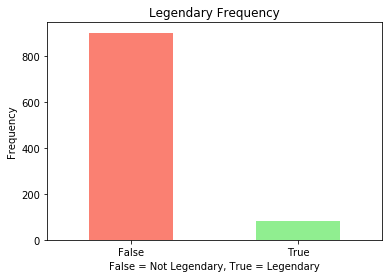

In [22]:
print(f'Legendary Frequency:\n{data.Legendary.value_counts()}')
print(f'\nLegendary Frequency, normalized:\n{data.Legendary.value_counts(normalize=True)}')
data.Legendary.value_counts().plot(kind="bar", color=["salmon", "lightgreen"]);
plt.title("Legendary Frequency");
plt.xlabel("False = Not Legendary, True = Legendary");
plt.ylabel("Frequency")
plt.xticks(rotation=0);

### 7.2.1. Legendary Frequency According to Primary Type

In [23]:
data['Type 1'].value_counts()

Water       131
Normal      114
Grass        90
Bug          81
Psychic      73
Fire         63
Rock         57
Electric     57
Ghost        40
Fighting     39
Dark         39
Dragon       38
Ground       37
Steel        35
Poison       35
Ice          27
Fairy        21
Flying        8
Name: Type 1, dtype: int64

In [24]:
pd.crosstab(data['Legendary'], data['Type 1'])

Type 1,Bug,Dark,Dragon,Electric,Fairy,Fighting,Fire,Flying,Ghost,Grass,Ground,Ice,Normal,Poison,Psychic,Rock,Steel,Water
Legendary,,,,,,,,,,,,,,,,,,
False,81,36,26,52,19,35,58,6,38,86,33,25,111,34,53,53,31,126
True,0,3,12,5,2,4,5,2,2,4,4,2,3,1,20,4,4,5


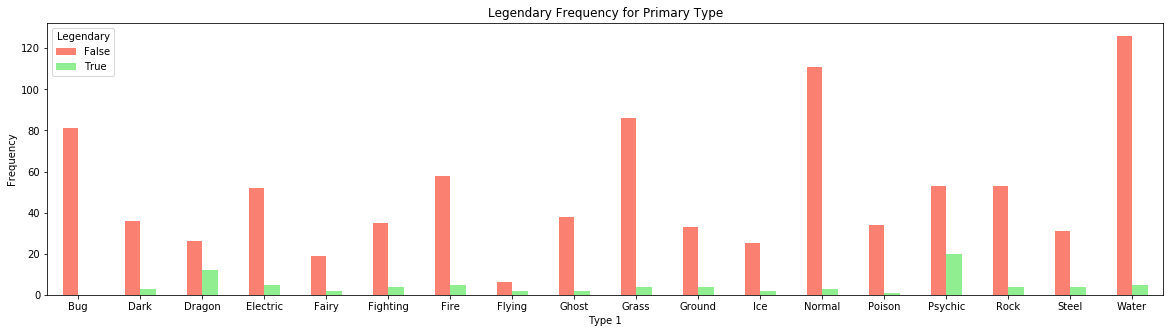

In [25]:
pd.crosstab(data['Type 1'], data.Legendary).plot(kind="bar", 
                                    figsize=(20, 5), 
                                    color=["salmon", "lightgreen"]);
plt.title("Legendary Frequency for Primary Type")
plt.ylabel("Frequency")
plt.xticks(rotation=0);

### 7.2.2. Legendary Frequency According to Secondary Type

In [26]:
data['Type 2'].value_counts()

Undef       469
Flying      109
Fairy        38
Poison       37
Ground       37
Psychic      37
Fighting     32
Dragon       30
Steel        30
Grass        27
Ghost        23
Dark         23
Water        20
Ice          18
Fire         16
Rock         15
Bug           9
Electric      8
Normal        7
Name: Type 2, dtype: int64

In [27]:
pd.crosstab(data['Legendary'], data['Type 2'])

Type 2,Bug,Dark,Dragon,Electric,Fairy,Fighting,Fire,Flying,Ghost,Grass,Ground,Ice,Normal,Poison,Psychic,Rock,Steel,Undef,Water
Legendary,,,,,,,,,,,,,,,,,,,
False,9,21,25,7,32,28,13,96,21,26,36,15,7,37,32,15,26,439,18
True,0,2,5,1,6,4,3,13,2,1,1,3,0,0,5,0,4,30,2


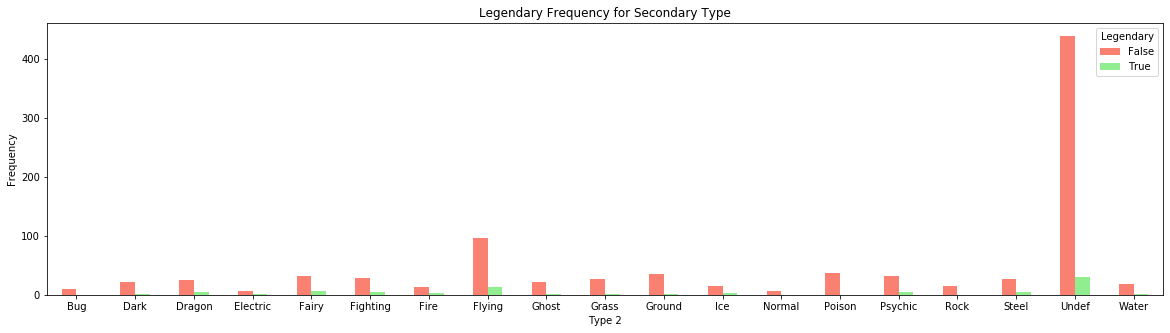

In [28]:
pd.crosstab(data['Type 2'], data.Legendary).plot(kind="bar", 
                                    figsize=(20, 5), 
                                    color=["salmon", "lightgreen"]);
plt.title("Legendary Frequency for Secondary Type")
plt.ylabel("Frequency")
plt.xticks(rotation=0);

## 7.3. Histograms for the Numerical Features

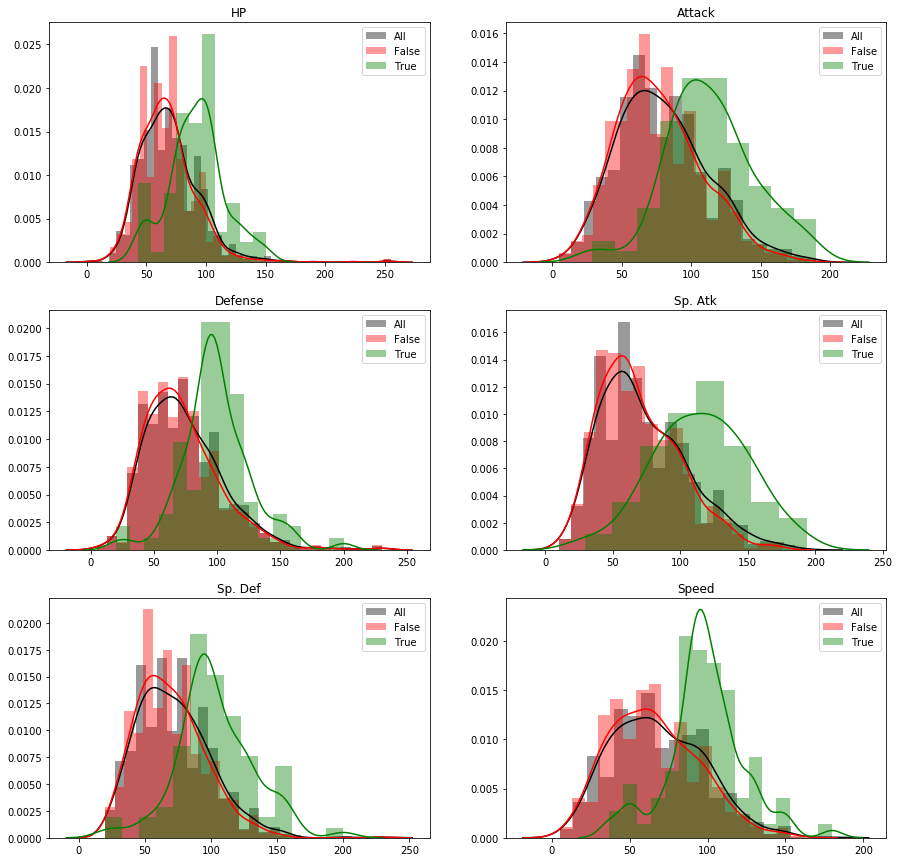

In [29]:
colors = ['red','green']
figure = plt.figure(figsize=(15, 15))
figure.subplots(nrows=3, ncols=2)
for feature_i in range(number_of_features-3):
    subplot = plt.subplot(3,2, feature_i+1)
    plt.title(features[feature_i])
    sns.distplot(X[:, feature_i], label="All", color='black')
    for class_i in range(number_of_classes):
        sns.distplot(X[y==class_i, feature_i], label=classes[class_i], color=colors[class_i])
    plt.legend()
plt.show()

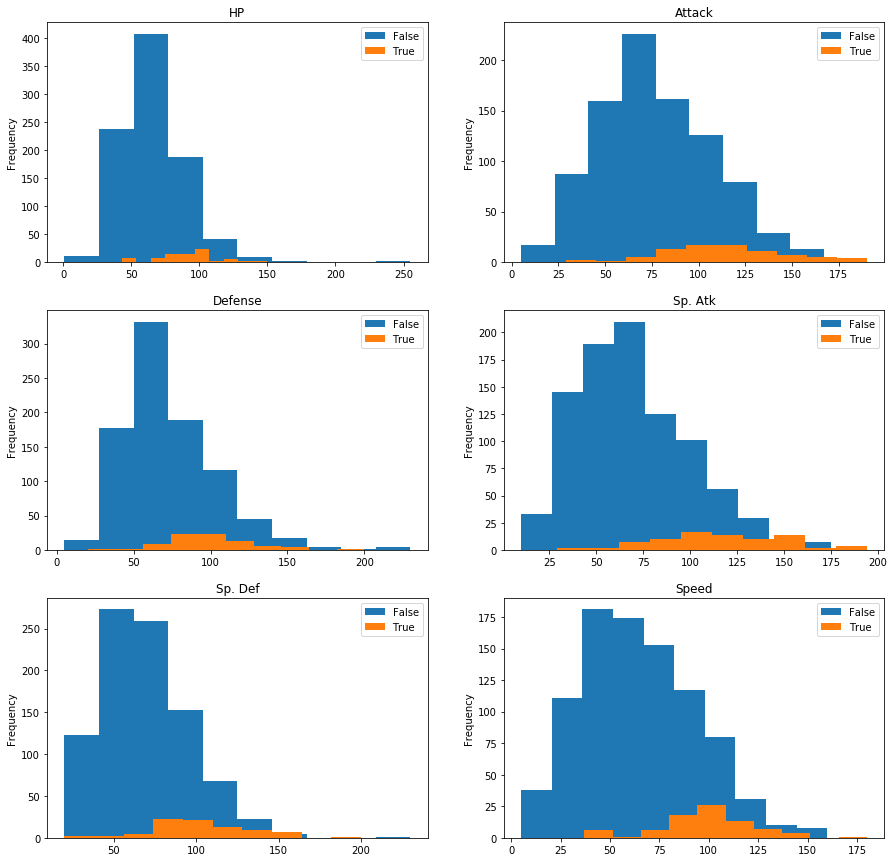

In [30]:
grouped = data.groupby('Legendary')
figure = plt.figure(figsize=(15, 15))
figure.subplots(nrows=3, ncols=2)
for feature_i in range(number_of_features-3):
    subplot = plt.subplot(3,2, feature_i+1)
    plt.title(features[feature_i])
    grouped[features[feature_i]].plot.hist()
    plt.legend()
plt.show()

## 7.4. Scatter Plots Every Feature vs. Every Other 

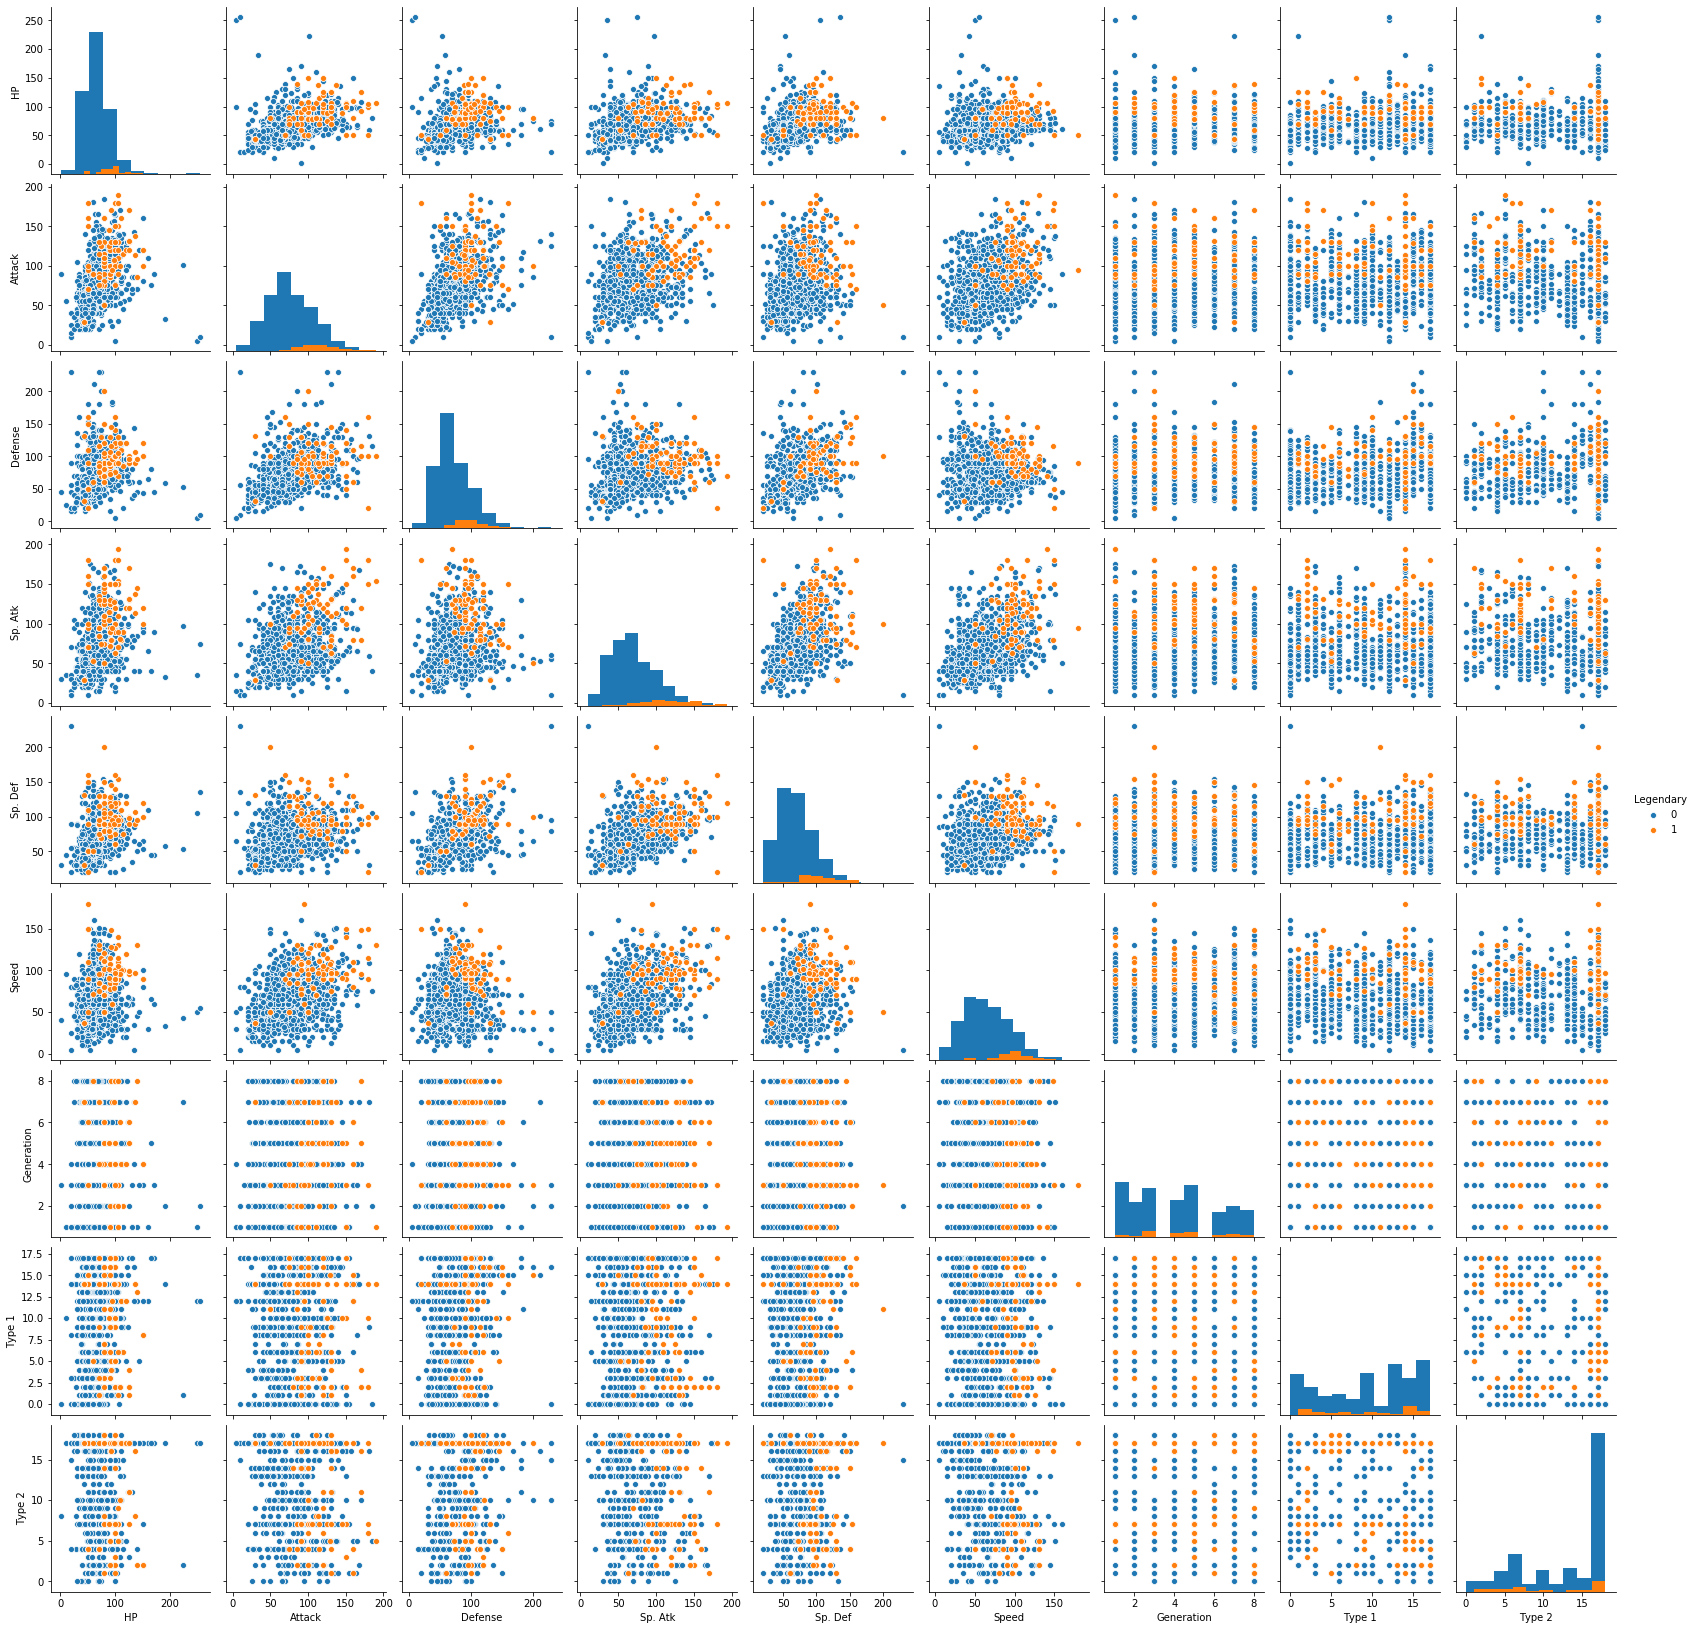

In [31]:
sns.pairplot(data_encoded, hue="Legendary",diag_kind="hist");

## 7.5. Parallel Coordinates

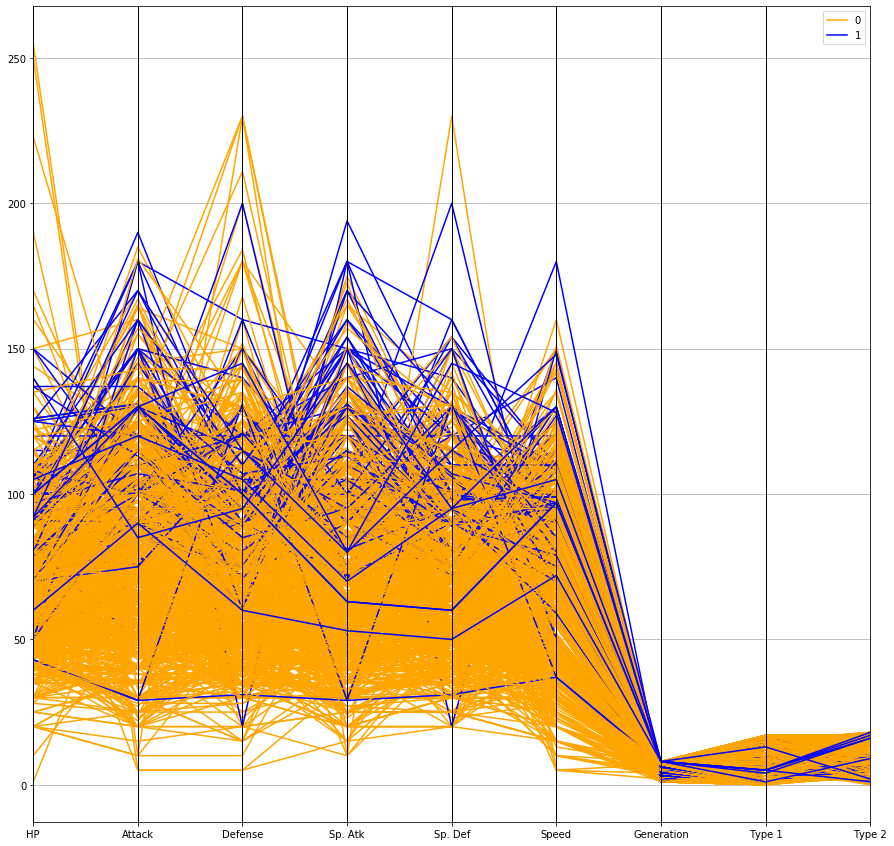

In [32]:
plt.figure(figsize=(15,15))
pd.plotting.parallel_coordinates(data_encoded,'Legendary', color=['orange','blue'])
plt.show()

## 7.6. Box Plot

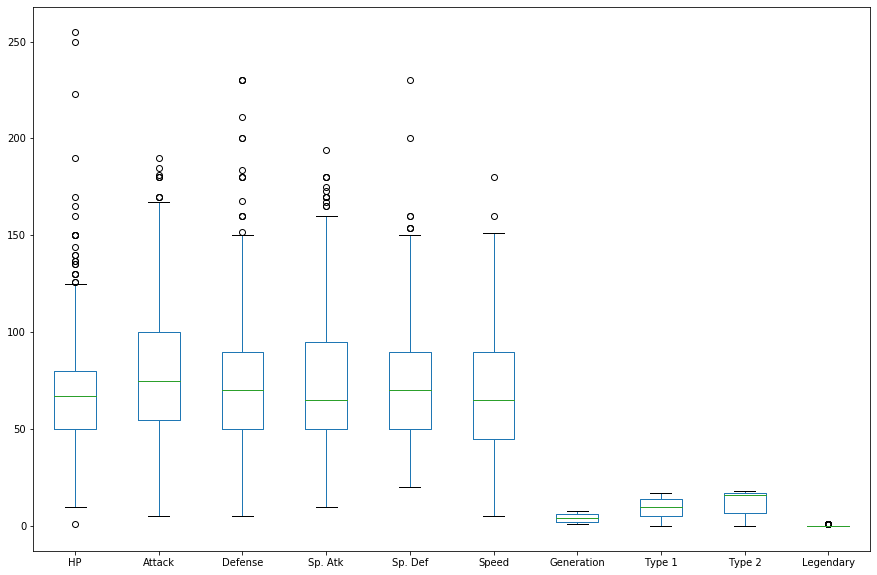

In [33]:
data_encoded.plot.box(figsize=(15,10));

We decided not to remove the outliers because they are not a result of a noise.

## 7.7. Correlation Matrix

In [34]:
correlation_matrix = data_encoded.corr()
correlation_matrix

,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Type 1,Type 2,Legendary
HP,1.000000,0.451960,0.270393,0.370740,0.368522,0.189202,0.043471,0.086569,-0.115455,0.266761
Attack,0.451960,1.000000,0.459238,0.380649,0.263652,0.383307,0.067426,-0.033738,-0.145909,0.315926
Defense,0.270393,0.459238,1.000000,0.223272,0.527025,0.010830,0.044973,0.103544,-0.071110,0.242289
Sp. Atk,0.370740,0.380649,0.223272,1.000000,0.511473,0.451086,0.028966,0.001080,-0.183536,0.386552
Sp. Def,0.368522,0.263652,0.527025,0.511473,1.000000,0.226465,0.020506,0.036927,-0.104761,0.337987
Speed,0.189202,0.383307,0.010830,0.451086,0.226465,1.000000,-0.027553,-0.082913,-0.149935,0.311666
Generation,0.043471,0.067426,0.044973,0.028966,0.020506,-0.027553,1.000000,-0.079259,-0.107036,0.057558
Type 1,0.086569,-0.033738,0.103544,0.001080,0.036927,-0.082913,-0.079259,1.000000,0.016426,-0.004505
Type 2,-0.115455,-0.145909,-0.071110,-0.183536,-0.104761,-0.149935,-0.107036,0.016426,1.000000,-0.078806
Legendary,0.266761,0.315926,0.242289,0.386552,0.337987,0.311666,0.057558,-0.004505,-0.078806,1.000000


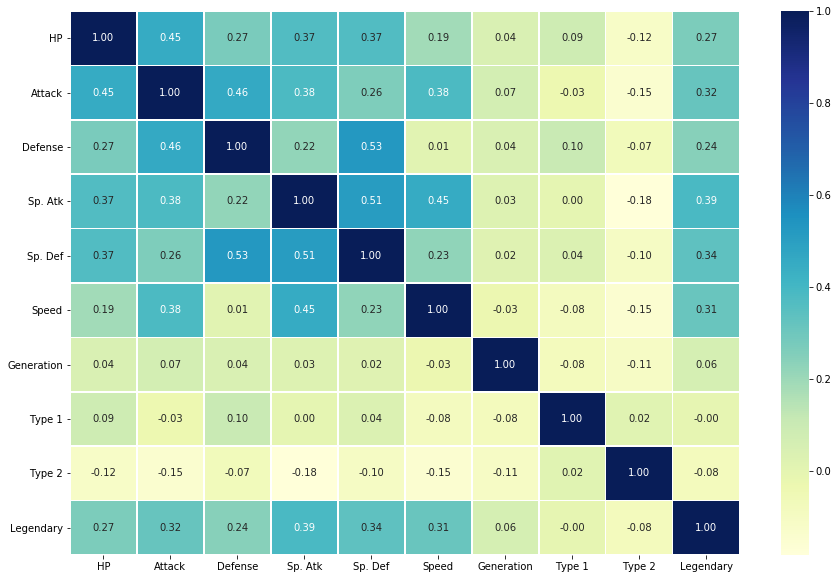

In [35]:
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, linewidths=0.7, fmt= ".2f", cmap="YlGnBu");

We can see from the visualisations and the correlation matrix at the end that the features 'Generation','Type 2' and 'Type 1' have very little impact on the class attribute, so we will remove them. We should've done that at the Feature Selection section, but we didn't in order to show techniques in preprocessing that otherwise wouldn't be done. So we will remove those features now.

In [36]:
data=data_encoded.drop(columns=['Generation','Type 2','Type 1'])
data_normalized=data_normalized.drop(columns=['Generation','Type 2','Type 1'])

In [193]:
print ("Data looks:")
print (data)
# Save data
data.to_csv('POKEMON.csv', index=False)
data_normalized.to_csv('POKEMON_NORMALIZED.csv', index=False)

Data looks:
      HP  Attack  Defense  Sp. Atk  Sp. Def  Speed  Legendary
0     45      49       49       65       65     45          0
1     60      62       63       80       80     60          0
2     80      82       83      100      100     80          0
3     80     100      123      122      120     80          0
4     39      52       43       60       50     65          0
..   ...     ...      ...      ...      ...    ...        ...
980  140      85       95      145       95    130          1
981   60      90       60       53       50     72          1
982  100     130      100       63       60     97          1
983  100     130      100       63       60     97          1
984  105     120      105       70       95    105          1

[985 rows x 7 columns]


From all the visualisations we can conclude that generally the legendary Pokemon tend to have higher values for all the attributes than the ones that aren't legendary.

# 8. Classification
We've explored the data, now we'll use machine learning to predict our target variable based on the 6 independent variables. Before we build a model, we have to get our dataset ready.

In [118]:
X = data.values[:, 0:-1]
y = data.values[:, -1]
X_normalized = data_normalized.values[:, 0:-1]
y_normalized = data_normalized.values[:, -1]

X constains all samples with their features and y contains the class attribute for every sample. X_normalized and y_normalized contain the coresponding normalized values.

## 8.1. Training Set and Test Set Split
We will split the dataset into training and test sets. The training set will contain 80% od the samples, and the test set the remaining 20%. There will be equal percentage of legendary Pokemons in the training and the test set.

In [119]:
np.random.seed(7)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1,stratify=y)
Xn_train, Xn_test, yn_train, yn_test = train_test_split(X_normalized, y_normalized, test_size=0.2, random_state=1,stratify=y)

In [120]:
print ("Training set size:",len(y_train))
print (Counter(y_train))

Training set size: 788
Counter({0: 722, 1: 66})


We can see we're using 788 samples to train on. 722 aren't legendary and 66 are.

In [121]:
print ("Test set size:",len(y_test))
print (Counter(y_test))

Test set size: 197
Counter({0: 181, 1: 16})


And we've got 197 examples we'll test our model(s) on. 181 pokemons are not legendary and 16 are.

We are now ready to start with classification. <br>
For every classificator we'll be using the following evaluations: <br>
- Classification report which contains the basic scores: accuracy, precision, recall and f1<br>
- Confusion matrix in shape:<br>
  [[ TN FP ]<br>
   [ FN TP ]]<br>
- Time required for the classifier to fit the training set<br>
- ROC curve with AUC score<br>

## 8.2. Classification Without Taking into Account that the Class is Imbalanced
In this section we will use some common classifiers without taking into account that the class is imbalanced, so we can later compare and show the improvement that the oversampling technique and the cost-sensitive classification make.
We will be using the following classifiers: Logistic Regression, Decision Tree Classifier, Support Vector Classificator and Random Forrest.
### 8.2.1. Logistic Regression

Classification report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       181
           1       0.38      0.31      0.34        16

    accuracy                           0.90       197
   macro avg       0.66      0.63      0.65       197
weighted avg       0.90      0.90      0.90       197

Confusion matrix:
[[173   8]
 [ 11   5]]
Accuracy score:  90.35532994923858
Precision score:  38.46153846153847
Recall score:  31.25
F1 score:  34.48275862068966

Time:  0.2930169105529785
ROC curve:


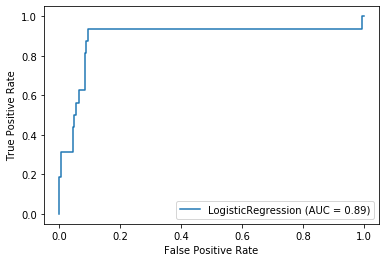

In [122]:
from sklearn.metrics import auc
np.random.seed(7)
logistic_regression= LogisticRegression()
start_time = time.time()
logistic_regression.fit(X_train,y_train)
y_pred=logistic_regression.predict(X_test)
finish_time = time.time()
lr_fit_time = finish_time-start_time

cr_lr=classification_report(y_test,y_pred)
cm_lr=confusion_matrix(y_test,y_pred)
a_lr=accuracy_score(y_test,y_pred)*100
p_lr=precision_score(y_test,y_pred)*100
r_lr=recall_score(y_test,y_pred)*100
f_lr=f1_score(y_test,y_pred)*100
lr_scores=[a_lr,p_lr,r_lr,f_lr]

print ("Classification report:")
print(cr_lr)
print ("Confusion matrix:")
print (cm_lr)
print ("Accuracy score: ",a_lr)
print ("Precision score: ",p_lr)
print ("Recall score: ",r_lr)
print ("F1 score: ",f_lr)
print ("\nTime: ",lr_fit_time)
print ("ROC curve:")
plot_roc_curve(logistic_regression,X_test, y_test);

### 8.2.2. Decision Tree Classifier

This Decision Tree Classifier uses gini index as a measure of a quality of a split. Additionaly we limit the maximum depth at 15.

Classification report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.95       181
           1       0.41      0.44      0.42        16

    accuracy                           0.90       197
   macro avg       0.68      0.69      0.69       197
weighted avg       0.91      0.90      0.90       197

Confusion matrix:
[[171  10]
 [  9   7]]
Accuracy score:  90.35532994923858
Precision score:  41.17647058823529
Recall score:  43.75
F1 score:  42.42424242424242

Time:  0.004000425338745117
ROC curve:


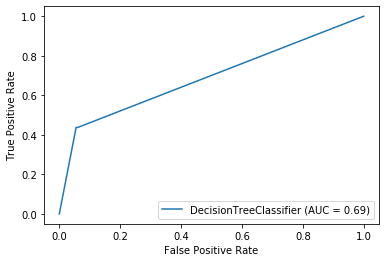

In [132]:
np.random.seed(7)
dt = DecisionTreeClassifier(max_depth=15)
start_time = time.time()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
finish_time = time.time()
dt_fit_time = finish_time-start_time

cr_dt=classification_report(y_test,y_pred)
cm_dt=confusion_matrix(y_test,y_pred)
a_dt=accuracy_score(y_test,y_pred)*100
p_dt=precision_score(y_test,y_pred)*100
r_dt=recall_score(y_test,y_pred)*100
f_dt=f1_score(y_test,y_pred)*100
dt_scores=[a_dt,p_dt,r_dt,f_dt]

print ("Classification report:")
print(cr_dt)
print ("Confusion matrix:")
print (cm_dt)
print ("Accuracy score: ",a_dt)
print ("Precision score: ",p_dt)
print ("Recall score: ",r_dt)
print ("F1 score: ",f_dt)
print ("\nTime: ",dt_fit_time)
print ("ROC curve:")
plot_roc_curve(dt,X_test, y_test);

### 8.2.3. Support Vector Machine (with RBF kernel)

Classification report:
              precision    recall  f1-score   support

         0.0       0.94      0.97      0.95       181
         1.0       0.45      0.31      0.37        16

    accuracy                           0.91       197
   macro avg       0.70      0.64      0.66       197
weighted avg       0.90      0.91      0.91       197

Confusion matrix:
[[175   6]
 [ 11   5]]
Accuracy score:  91.37055837563452
Precision score:  45.45454545454545
Recall score:  31.25
F1 score:  37.03703703703703

Time:  0.05500292778015137
ROC curve:


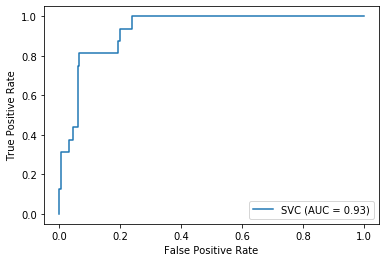

In [124]:
np.random.seed(7)
svc = SVC()
start_time = time.time()
svc.fit(Xn_train, yn_train)
y_pred = svc.predict(Xn_test)
finish_time = time.time()
svc_fit_time = finish_time-start_time

cr_svc=classification_report(yn_test,y_pred)
cm_svc=confusion_matrix(yn_test,y_pred)
a_svc=accuracy_score(yn_test,y_pred)*100
p_svc=precision_score(yn_test,y_pred)*100
r_svc=recall_score(yn_test,y_pred)*100
f_svc=f1_score(yn_test,y_pred)*100
svc_scores=[a_svc,p_svc,r_svc,f_svc]

print ("Classification report:")
print(cr_svc)
print ("Confusion matrix:")
print (cm_svc)
print ("Accuracy score: ",a_svc)
print ("Precision score: ",p_svc)
print ("Recall score: ",r_svc)
print ("F1 score: ",f_svc)
print ("\nTime: ",svc_fit_time)
print ("ROC curve:")
plot_roc_curve(svc,Xn_test, y_test);

### 8.2.4. Random Forest Classifier
We are using 15 basic estimatiors.

Classification report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       181
           1       0.58      0.44      0.50        16

    accuracy                           0.93       197
   macro avg       0.77      0.70      0.73       197
weighted avg       0.92      0.93      0.92       197

Confusion matrix:
[[176   5]
 [  9   7]]
Accuracy score:  92.89340101522842
Precision score:  58.333333333333336
Recall score:  43.75
F1 score:  50.0

Time:  0.07900476455688477
ROC curve:


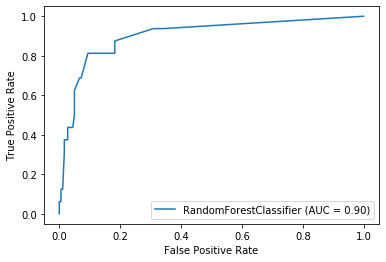

In [128]:
np.random.seed(7)
random_forest = RandomForestClassifier(max_depth=10, random_state=0,n_estimators=15)
start_time = time.time()
random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)
finish_time = time.time()
rf_fit_time = finish_time-start_time

cr_rf=classification_report(y_test,y_pred)
cm_rf=confusion_matrix(y_test,y_pred)
a_rf=accuracy_score(y_test,y_pred)*100
p_rf=precision_score(y_test,y_pred)*100
r_rf=recall_score(y_test,y_pred)*100
f_rf=f1_score(y_test,y_pred)*100
rf_scores=[a_rf,p_rf,r_rf,f_rf]

print ("Classification report:")
print(cr_rf)
print ("Confusion matrix:")
print (cm_rf)
print ("Accuracy score: ",a_rf)
print ("Precision score: ",p_rf)
print ("Recall score: ",r_rf)
print ("F1 score: ",f_rf)
print ("\nTime: ",rf_fit_time)
print ("ROC curve:")
plot_roc_curve(random_forest,X_test, y_test);

### 8.2.5. Models Comparison

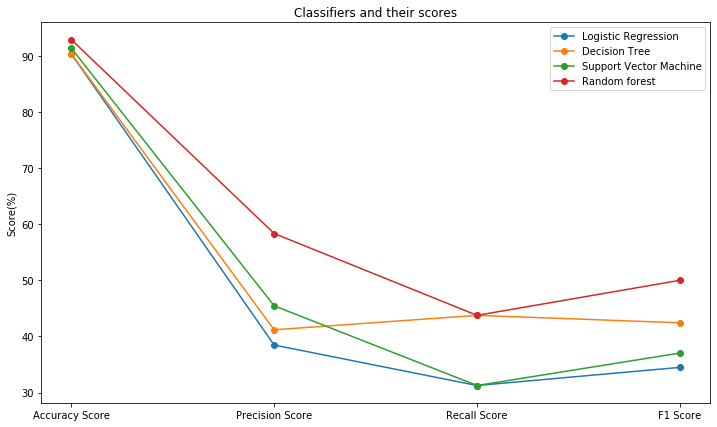

In [133]:
plt.figure(figsize=(12,7))
plt.ylabel("Score(%)")
plt.title("Classifiers and their scores")
plt.plot(lr_scores, marker="o", label="Logistic Regression")
plt.plot(dt_scores, marker="o", label="Decision Tree")
plt.plot(svc_scores, marker="o", label="Support Vector Machine")
plt.plot(rf_scores, marker="o", label="Random forest")
ax = plt.gca()
ax.set_xticks(np.arange(4))
ax.set_xticklabels([ "Accuracy Score","Precision Score", "Recall Score","F1 Score"])
plt.legend()
plt.show()

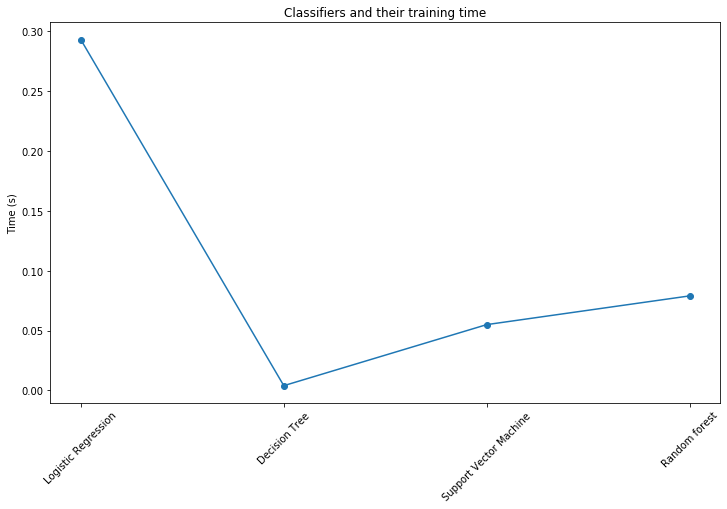

In [134]:
plt.figure(figsize=(12,7))
plt.ylabel("Time (s)")
plt.title("Classifiers and their training time")
plt.plot([lr_fit_time, dt_fit_time, svc_fit_time, rf_fit_time], marker="o")
ax = plt.gca()
ax.set_xticks(np.arange(4))
ax.set_xticklabels(["Logistic Regression", "Decision Tree","Support Vector Machine", "Random forest"], rotation=45)
plt.show()

##  8.3. Cost Sensitive Classification
By adding class_weight='balanced' to a classifier, we are giving weights to each class - 0 and 1 in our case. This way of modifying the algorithms is using the costs as a penalty for misclassification when the algorithms are trained. Given that most machine learning algorithms are trained to minimize error, cost for misclassification is added to the error or used to weigh the error during the training process. The weights are inversely proportional to class frequencies in the training data.
In short, we are penalizing a misclassification of a legendary Pokemon as false 722/66 ~ 11 times more than misclassifying a not-legendary Pokemon as true.
We are going to use the same parameters for the classifiers as in the previous section.
### 8.3.1. Logistic Regression

Classification report:
              precision    recall  f1-score   support

           0       0.99      0.84      0.91       181
           1       0.34      0.94      0.50        16

    accuracy                           0.85       197
   macro avg       0.67      0.89      0.71       197
weighted avg       0.94      0.85      0.88       197

Confusion matrix:
[[152  29]
 [  1  15]]
Accuracy score:  84.77157360406092
Precision score:  34.090909090909086
Recall score:  93.75
F1 score:  50.0

Time:  0.32501864433288574
ROC curve:


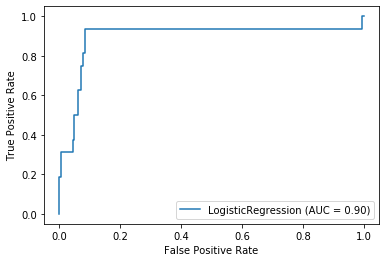

In [131]:
np.random.seed(7)
logistic_regression= LogisticRegression(class_weight='balanced')
start_time = time.time()
logistic_regression.fit(X_train,y_train)
y_pred=logistic_regression.predict(X_test)
finish_time = time.time()
clr_fit_time = finish_time-start_time

cr_clr=classification_report(y_test,y_pred)
cm_clr=confusion_matrix(y_test,y_pred)
a_clr=accuracy_score(y_test,y_pred)*100
p_clr=precision_score(y_test,y_pred)*100
r_clr=recall_score(y_test,y_pred)*100
f_clr=f1_score(y_test,y_pred)*100
clr_scores=[a_clr,p_clr,r_clr,f_clr]

print ("Classification report:")
print(cr_clr)
print ("Confusion matrix:")
print (cm_clr)
print ("Accuracy score: ",a_clr)
print ("Precision score: ",p_clr)
print ("Recall score: ",r_clr)
print ("F1 score: ",f_clr)
print ("\nTime: ",clr_fit_time)
print ("ROC curve:")
plot_roc_curve(logistic_regression,X_test, y_test);

### 8.3.2. Decision Tree Classifier

Classification report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       181
           1       0.44      0.50      0.47        16

    accuracy                           0.91       197
   macro avg       0.70      0.72      0.71       197
weighted avg       0.91      0.91      0.91       197

Confusion matrix:
[[171  10]
 [  8   8]]
Accuracy score:  90.86294416243655
Precision score:  44.44444444444444
Recall score:  50.0
F1 score:  47.05882352941176

Time:  0.005000114440917969
ROC curve:


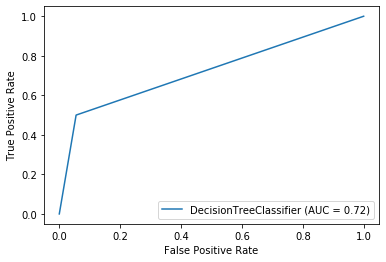

In [135]:
np.random.seed(7)
cdt = DecisionTreeClassifier(max_depth=15,class_weight='balanced')
start_time = time.time()
cdt.fit(X_train, y_train)
y_pred = cdt.predict(X_test)
finish_time = time.time()
cdt_fit_time = finish_time-start_time

cr_cdt=classification_report(y_test,y_pred)
cm_cdt=confusion_matrix(y_test,y_pred)
a_cdt=accuracy_score(y_test,y_pred)*100
p_cdt=precision_score(y_test,y_pred)*100
r_cdt=recall_score(y_test,y_pred)*100
f_cdt=f1_score(y_test,y_pred)*100
cdt_scores=[a_cdt,p_cdt,r_cdt,f_cdt]

print ("Classification report:")
print(cr_cdt)
print ("Confusion matrix:")
print (cm_cdt)
print ("Accuracy score: ",a_cdt)
print ("Precision score: ",p_cdt)
print ("Recall score: ",r_cdt)
print ("F1 score: ",f_cdt)
print ("\nTime: ",cdt_fit_time)
print ("ROC curve:")
plot_roc_curve(cdt,X_test, y_test);

### 8.3.3. Support Vector Machine (with RBF kernel)

Classification report:
              precision    recall  f1-score   support

         0.0       0.99      0.90      0.94       181
         1.0       0.45      0.94      0.61        16

    accuracy                           0.90       197
   macro avg       0.72      0.92      0.78       197
weighted avg       0.95      0.90      0.92       197

Confusion matrix:
[[163  18]
 [  1  15]]
Accuracy score:  90.35532994923858
Precision score:  45.45454545454545
Recall score:  93.75
F1 score:  61.224489795918366

Time:  0.10500597953796387
ROC curve:


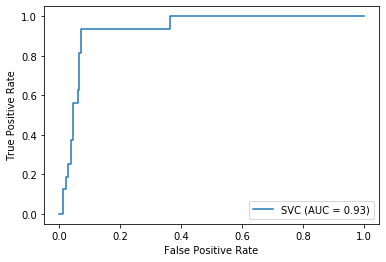

In [136]:
np.random.seed(7)
svc = SVC(class_weight='balanced')
start_time = time.time()
svc.fit(Xn_train, yn_train)
y_pred = svc.predict(Xn_test)
finish_time = time.time()
csvc_fit_time = finish_time-start_time

cr_csvc=classification_report(yn_test,y_pred)
cm_csvc=confusion_matrix(yn_test,y_pred)
a_csvc=accuracy_score(yn_test,y_pred)*100
p_csvc=precision_score(yn_test,y_pred)*100
r_csvc=recall_score(yn_test,y_pred)*100
f_csvc=f1_score(yn_test,y_pred)*100
csvc_scores=[a_csvc,p_csvc,r_csvc,f_csvc]

print ("Classification report:")
print(cr_csvc)
print ("Confusion matrix:")
print (cm_csvc)
print ("Accuracy score: ",a_csvc)
print ("Precision score: ",p_csvc)
print ("Recall score: ",r_csvc)
print ("F1 score: ",f_csvc)
print ("\nTime: ",csvc_fit_time)
print ("ROC curve:")
plot_roc_curve(svc,Xn_test, y_test);

### 8.3.4. Random Forest Classifier

Classification report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       181
           1       0.67      0.50      0.57        16

    accuracy                           0.94       197
   macro avg       0.81      0.74      0.77       197
weighted avg       0.93      0.94      0.94       197

Confusion matrix:
[[177   4]
 [  8   8]]
Accuracy score:  93.90862944162437
Precision score:  66.66666666666666
Recall score:  50.0
F1 score:  57.14285714285715

Time:  0.0890049934387207
ROC curve:


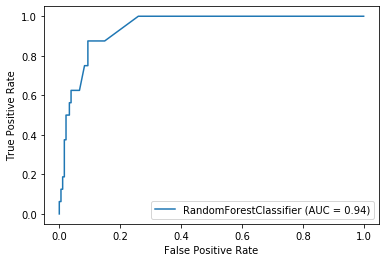

In [138]:
np.random.seed(7)
random_forest = RandomForestClassifier(max_depth=10, random_state=0,class_weight='balanced',n_estimators=15)
start_time = time.time()
random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)
finish_time = time.time()
crf_fit_time = finish_time-start_time

cr_crf=classification_report(y_test,y_pred)
cm_crf=confusion_matrix(y_test,y_pred)
a_crf=accuracy_score(y_test,y_pred)*100
p_crf=precision_score(y_test,y_pred)*100
r_crf=recall_score(y_test,y_pred)*100
f_crf=f1_score(y_test,y_pred)*100
crf_scores=[a_crf,p_crf,r_crf,f_crf]

print ("Classification report:")
print(cr_crf)
print ("Confusion matrix:")
print (cm_crf)
print ("Accuracy score: ",a_crf)
print ("Precision score: ",p_crf)
print ("Recall score: ",r_crf)
print ("F1 score: ",f_crf)
print ("\nTime: ",crf_fit_time)
print ("ROC curve:")
plot_roc_curve(random_forest,X_test, y_test);

## 8.4. Comparing All Cost Sensitive and Normal Classifiers

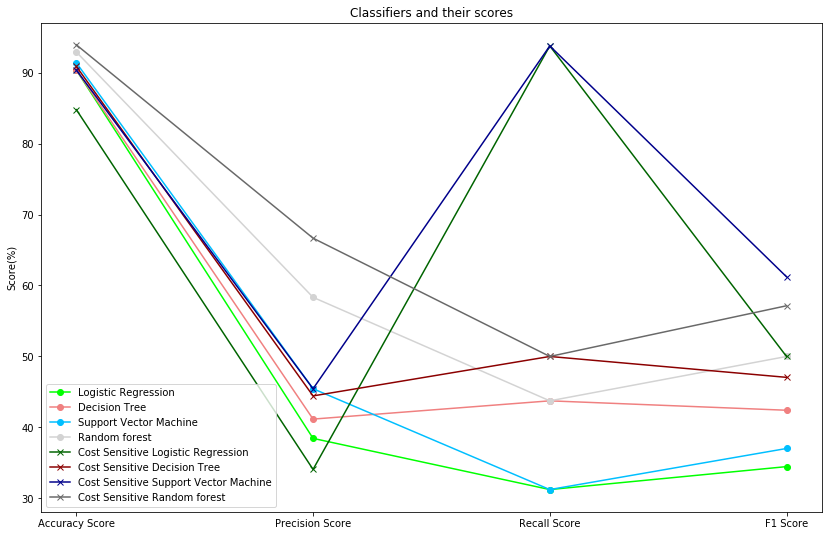

In [139]:
plt.figure(figsize=(14,9))
plt.ylabel("Score(%)")
plt.title("Classifiers and their scores")
plt.plot(lr_scores, marker="o", label="Logistic Regression",color='lime')
plt.plot(dt_scores, marker="o", label="Decision Tree",color='lightcoral')
plt.plot(svc_scores, marker="o", label="Support Vector Machine",color='deepskyblue')
plt.plot(rf_scores, marker="o", label="Random forest",color='lightgray')
plt.plot(clr_scores, marker="x", label="Cost Sensitive Logistic Regression",color='darkgreen')
plt.plot(cdt_scores, marker="x", label="Cost Sensitive Decision Tree",color='darkred')
plt.plot(csvc_scores, marker="x", label="Cost Sensitive Support Vector Machine",color='darkblue')
plt.plot(crf_scores, marker="x", label="Cost Sensitive Random forest",color='dimgray')

ax = plt.gca()
ax.set_xticks(np.arange(4))
ax.set_xticklabels([ "Accuracy Score","Precision Score", "Recall Score","F1 Score"])
plt.legend()
plt.show()

The classifiers in which we used cost-sensitive classification are plotted with dark colors, and the normal ones are in the corresponding lighter color.

From the graph we can see that the Random Forrest, SVM and the Decision Tree Classifiers are better in their cost-sensitive variant in every score. 
The Logistic Regression's cost-sensitive variant by far outperforms its coresponding normal variant in the recall score which is very logical, considering that we penalized every false negative predicted sample more than the false positive predicted samples. But that comes with a price - its percision  and accuracy scores are lower.

Overall the cost-sensitive classifiers are much better than the normal ones - they have about 15% increase in the f1 score.

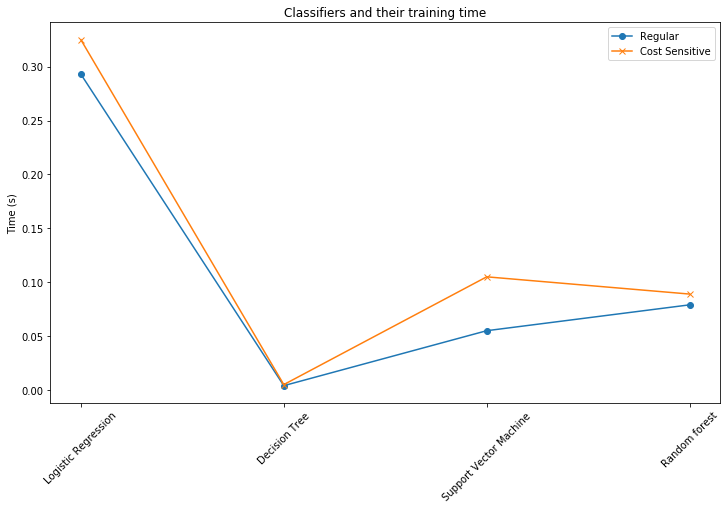

In [141]:
plt.figure(figsize=(12,7))
plt.ylabel("Time (s)")
plt.title("Classifiers and their training time")
plt.plot([lr_fit_time, dt_fit_time, svc_fit_time, rf_fit_time], marker="o",label="Regular")
plt.plot([clr_fit_time, cdt_fit_time,csvc_fit_time, crf_fit_time], marker="x",label="Cost Sensitive")
ax = plt.gca()
ax.set_xticks(np.arange(4))
ax.set_xticklabels(["Logistic Regression", "Decision Tree","Support Vector Machine", "Random forest"], rotation=45)
plt.legend()
plt.show()

Overall cost-sensitive classifiers require inconsiderably more time than their normal variants.

## 8.5. Classification After Applying Synthetic Minority Oversampling Technique (SMOTE)
SMOTE works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line. It does not add additional information, it only adjusts the existing data so that there would be balance in the number of records for the both values of the target feature.

In [142]:
np.random.seed(7)
print (Counter(y))
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_res))

Counter({0: 903, 1: 82})
Resampled dataset shape Counter({0: 903, 1: 903})


Now we have equal number of samples from each class. 821 true legendary Pokemon were added.

In [143]:
print (X_res.shape)
print (y_res.shape)

(1806, 6)
(1806,)


After applying SMOTE technique, we have 1806 samples in total.

### 8.5.1. Training Set and Test Set Split
We need new splitting into training and test sets.

In [144]:
np.random.seed(7)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=1,stratify=y_res)

Some classifiers require normalized data. We will normalize X_train and X_test to the variables Xn_train and Xn_test accordingly, for later use.

In [145]:
Xn_train=X_train
scaler = MinMaxScaler() 
scaled_values = scaler.fit_transform(Xn_train) 
Xn_train = scaled_values

Xn_test=X_test
scaled_values = scaler.fit_transform(Xn_test) 
Xn_test = scaled_values

### 8.5.2. Logistic Regression Classifier

Classification report:
              precision    recall  f1-score   support

           0       0.96      0.85      0.90       181
           1       0.87      0.97      0.91       181

    accuracy                           0.91       362
   macro avg       0.91      0.91      0.91       362
weighted avg       0.91      0.91      0.91       362

Confusion matrix:
[[154  27]
 [  6 175]]
Accuracy score:  90.88397790055248
Precision score:  86.63366336633663
Recall score:  96.68508287292818
F1 score:  91.38381201044385

Time:  0.32501864433288574
ROC curve:


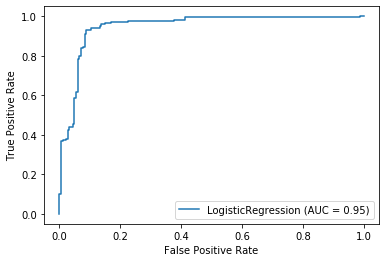

In [146]:
np.random.seed(7)
logistic_regression = LogisticRegression()
start_time = time.time()
logistic_regression.fit(X_train, y_train)
y_pred = logistic_regression.predict(X_test)
finish_time = time.time()
slr_fit_time = finish_time-start_time

cr_slr=classification_report(y_test,y_pred)
cm_slr=confusion_matrix(y_test,y_pred)
a_slr=accuracy_score(y_test,y_pred)*100
p_slr=precision_score(y_test,y_pred)*100
r_slr=recall_score(y_test,y_pred)*100
f_slr=f1_score(y_test,y_pred)*100
slr_scores=[a_slr,p_slr,r_slr,f_slr]
print ("Classification report:")
print(cr_slr)
print ("Confusion matrix:")
print (cm_slr)
print ("Accuracy score: ",a_slr)
print ("Precision score: ",p_slr)
print ("Recall score: ",r_slr)
print ("F1 score: ",f_slr)
print ("\nTime: ",slr_fit_time)
print ("ROC curve:")
plot_roc_curve(logistic_regression,X_test, y_test);

Comparison to the previous, simpler Logistic Regressions:

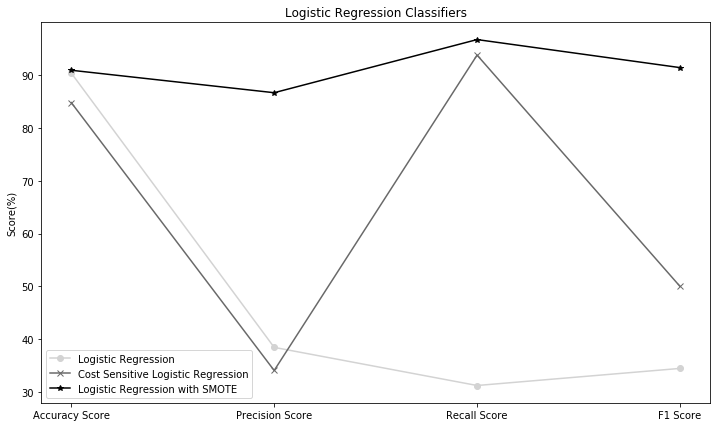

In [157]:
plt.figure(figsize=(12,7))
plt.title("Logistic Regression Classifiers")
plt.ylabel("Score(%)")
plt.plot(lr_scores, marker="o", label="Logistic Regression",color='lightgray')
plt.plot(clr_scores, marker="x", label="Cost Sensitive Logistic Regression",color='dimgray')
plt.plot(slr_scores, marker="*", label="Logistic Regression with SMOTE",color='black')

ax = plt.gca()
ax.set_xticks(np.arange(4))
ax.set_xticklabels([ "Accuracy Score","Precision Score", "Recall Score","F1 Score"])
plt.legend()
plt.show()

### 8.5.3. Gaussian Naive Bayes

Classification report:
              precision    recall  f1-score   support

           0       0.95      0.81      0.88       181
           1       0.84      0.96      0.89       181

    accuracy                           0.89       362
   macro avg       0.90      0.89      0.89       362
weighted avg       0.90      0.89      0.89       362

Confusion matrix:
[[147  34]
 [  7 174]]
Accuracy score:  88.67403314917127
Precision score:  83.65384615384616
Recall score:  96.13259668508287
F1 score:  89.46015424164524

Time:  0.004000186920166016
ROC curve:


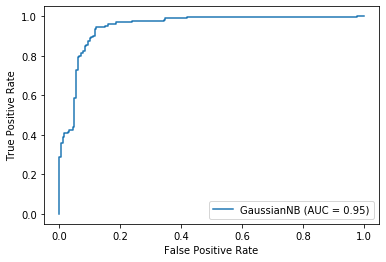

In [148]:
np.random.seed(7)
gnb = GaussianNB()
start_time = time.time()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)
finish_time = time.time()
gnb_fit_time = finish_time-start_time

cr_gnb=classification_report(y_test,y_pred)
cm_gnb=confusion_matrix(y_test,y_pred)
a_gnb=accuracy_score(y_test,y_pred)*100
p_gnb=precision_score(y_test,y_pred)*100
r_gnb=recall_score(y_test,y_pred)*100
f_gnb=f1_score(y_test,y_pred)*100
gnb_scores=[a_gnb,p_gnb,r_gnb,f_gnb]
print ("Classification report:")
print(cr_gnb)
print ("Confusion matrix:")
print (cm_gnb)
print ("Accuracy score: ",a_gnb)
print ("Precision score: ",p_gnb)
print ("Recall score: ",r_gnb)
print ("F1 score: ",f_gnb)
print ("\nTime: ",gnb_fit_time)
print ("ROC curve:")
plot_roc_curve(gnb,X_test, y_test);

### 8.5.4. Decision Tree Classifier
We will find the best Decision Tree Clasifier by trying different parameters. For maximum depth we will try every number in the range form 1 to 29, and for a measure of quality of a split we'll try gini index and entropy. 

Maximum Gini tree accuracy score on the test data:  93.646408839779  at max depth:  11
Maximum Gini f1 score on the test data:  93.80053908355795  at max depth:  11
Maximum Entropy tree accuracy score on the test data:  92.81767955801105  at max depth:  12
Maximum Entropy f1 score on the test data:  93.04812834224599  at max depth:  12


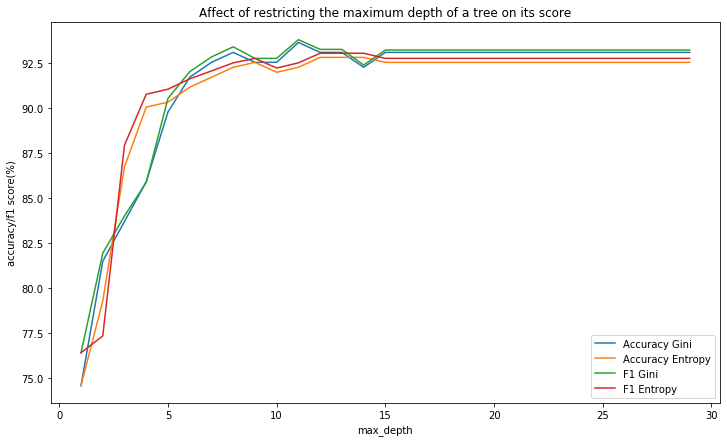

In [149]:
max_depth = []
acc_gini = []
acc_entropy = []
f1_gini =[]
f1_entropy = []
start_time = time.time()
for i in range(1,30):
 np.random.seed(7)
 dtree = DecisionTreeClassifier(criterion='gini', max_depth=i)
 dtree.fit(X_train, y_train)
 pred = dtree.predict(X_test)
 acc_gini.append(accuracy_score(y_test, pred)*100)
 f1_gini.append(f1_score(y_test, pred)*100)
 ####
 dtree = DecisionTreeClassifier(criterion='entropy', max_depth=i)
 dtree.fit(X_train, y_train)
 pred = dtree.predict(X_test)
 acc_entropy.append(accuracy_score(y_test, pred)*100)
 f1_entropy.append(f1_score(y_test, pred)*100)
 ####
 max_depth.append(i)
finish_time = time.time()
sdt_fit_time = finish_time-start_time
d = pd.DataFrame({'acc_gini':pd.Series(acc_gini), 
 'acc_entropy':pd.Series(acc_entropy),
 'f1_gini':pd.Series(f1_gini),                 
 'f1_entropy':pd.Series(f1_entropy),                 
 'max_depth':pd.Series(max_depth)})
# visualizing changes in parameters
plt.figure(figsize=(12,7))
plt.title("Affect of restricting the maximum depth of a tree on its score")
plt.plot('max_depth','acc_gini', data=d, label='Accuracy Gini')
plt.plot('max_depth','acc_entropy', data=d, label='Accuracy Entropy')
plt.plot('max_depth','f1_gini', data=d, label='F1 Gini')
plt.plot('max_depth','f1_entropy', data=d, label='F1 Entropy')
plt.xlabel('max_depth')
plt.ylabel('accuracy/f1 score(%)')
plt.legend();
print("Maximum Gini tree accuracy score on the test data: ",max(acc_gini)," at max depth: ",np.argmax(acc_gini)+1)
print("Maximum Gini f1 score on the test data: ",max(f1_gini)," at max depth: ",np.argmax(f1_gini)+1)
print("Maximum Entropy tree accuracy score on the test data: ",max(acc_entropy)," at max depth: ",np.argmax(acc_entropy)+1)
print("Maximum Entropy f1 score on the test data: ",max(f1_entropy)," at max depth: ",np.argmax(f1_entropy)+1)

We found out that the best Decision Tree Clasifier uses gini index and its maximum depth is 11.
We will construct it once again, to save the scores for later comparison with other classifiers.

Classification report:
              precision    recall  f1-score   support

           0       0.96      0.91      0.93       181
           1       0.92      0.96      0.94       181

    accuracy                           0.94       362
   macro avg       0.94      0.94      0.94       362
weighted avg       0.94      0.94      0.94       362

Confusion matrix:
[[165  16]
 [  7 174]]
Accuracy score:  93.646408839779
Precision score:  91.57894736842105
Recall score:  96.13259668508287
F1 score:  93.80053908355795

Time:  0.595034122467041
ROC curve:


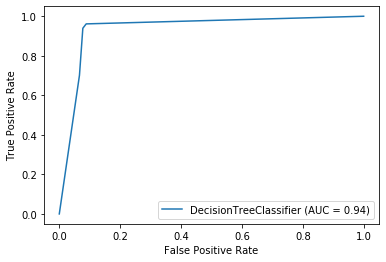

In [150]:
np.random.seed(7)
sdt = DecisionTreeClassifier(max_depth=11)
sdt.fit(X_train, y_train)
y_pred = sdt.predict(X_test)

cr_sdt=classification_report(y_test,y_pred)
cm_sdt=confusion_matrix(y_test,y_pred)
a_sdt=accuracy_score(y_test,y_pred)*100
p_sdt=precision_score(y_test,y_pred)*100
r_sdt=recall_score(y_test,y_pred)*100
f_sdt=f1_score(y_test,y_pred)*100
sdt_scores=[a_sdt,p_sdt,r_sdt,f_sdt]

print ("Classification report:")
print(cr_sdt)
print ("Confusion matrix:")
print (cm_sdt)
print ("Accuracy score: ",a_sdt)
print ("Precision score: ",p_sdt)
print ("Recall score: ",r_sdt)
print ("F1 score: ",f_sdt)
print ("\nTime: ",sdt_fit_time)
print ("ROC curve:")
plot_roc_curve(sdt,X_test, y_test);

Comparison to the previous, simpler Decision Trees:

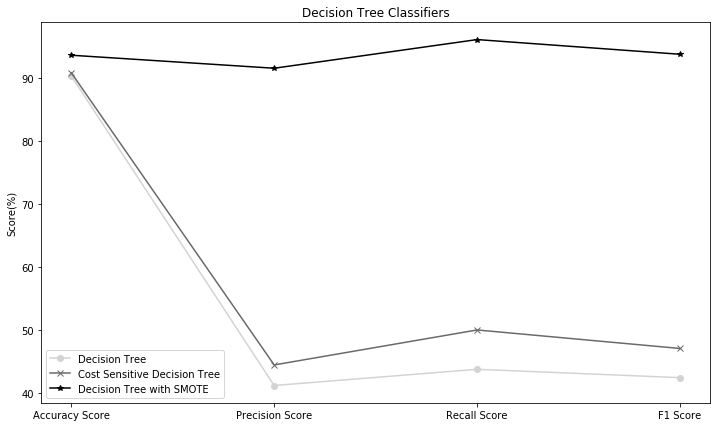

In [158]:
plt.figure(figsize=(12,7))
plt.title("Decision Tree Classifiers")
plt.ylabel("Score(%)")
plt.plot(dt_scores, marker="o", label="Decision Tree",color='lightgray')
plt.plot(cdt_scores, marker="x", label="Cost Sensitive Decision Tree",color='dimgray')
plt.plot(sdt_scores, marker="*", label="Decision Tree with SMOTE",color='black')

ax = plt.gca()
ax.set_xticks(np.arange(4))
ax.set_xticklabels([ "Accuracy Score","Precision Score", "Recall Score","F1 Score"])
plt.legend()
plt.show()

### 8.5.5. K-nearest Neighbors Classifier
This algorithm has one hyperparametar which we can tune and that is K - the number of neighbours. 
We will try with every number in the range from 1 to 19, and see what works best. This classifier uses Euclidean distance as a distance metric.

We ran the following code on the normalized data, but it gave us worse results. We assume that is due to the very similar rangs of all the features - none of the features points out as more important than the others.

Maximum KNN accuracy score on the test data:  93.92265193370166 at k= 1
Maximum KNN f1 score on the test data:  94.17989417989418 at k= 4


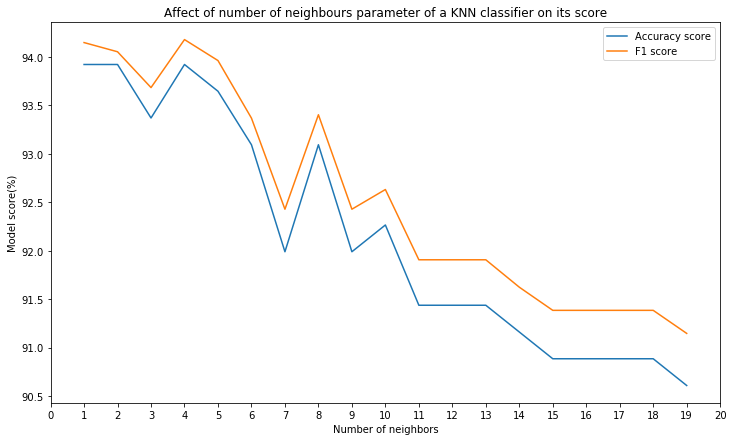

In [152]:
accuracy_scores = []
f1_scores = []
neighbors = range(1, 20)
knn = KNeighborsClassifier()

start_time = time.time()
for i in neighbors:
    np.random.seed(7)
    knn.set_params(n_neighbors = i)
    knn.fit(X_train, y_train)
    y_pred=knn.predict(X_test)    
    accuracy_scores.append(accuracy_score(y_test,y_pred)*100)
    f1_scores.append(f1_score(y_test,y_pred)*100)
finish_time = time.time()
knn_fit_time = finish_time-start_time
plt.figure(figsize=(12,7))
plt.title("Affect of number of neighbours parameter of a KNN classifier on its score")
plt.plot(neighbors,accuracy_scores , label="Accuracy score")
plt.plot(neighbors, f1_scores, label="F1 score")
plt.xticks(np.arange(0, 21, 1))
plt.xlabel("Number of neighbors")
plt.ylabel("Model score(%)")
plt.legend()

print("Maximum KNN accuracy score on the test data: ",max(accuracy_scores), "at k=",np.argmax(accuracy_scores)+1)
print("Maximum KNN f1 score on the test data: ",max(f1_scores), "at k=",np.argmax(f1_scores)+1)

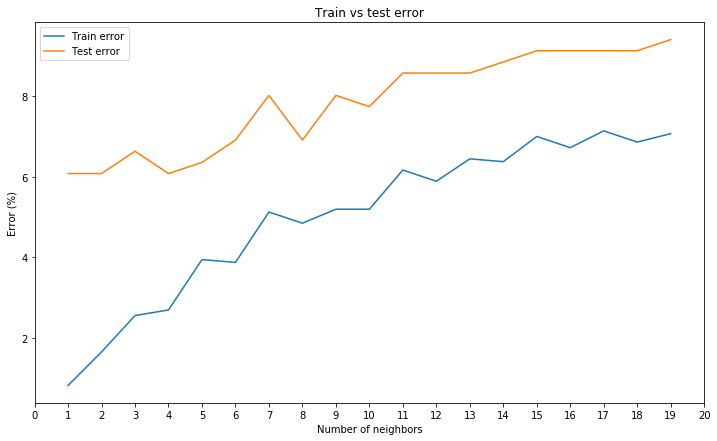

In [153]:
accuracy_scores_train = []
accuracy_scores_test = []

for i in neighbors:
    np.random.seed(7)
    knn.set_params(n_neighbors = i)
    knn.fit(X_train, y_train)
    y_pred=knn.predict(X_test)    
    accuracy_scores_train.append(100-knn.score(X_train,y_train)*100)
    accuracy_scores_test.append(100-knn.score(X_test,y_test)*100)

plt.figure(figsize=(12,7))
plt.title("Train vs test error")
plt.plot(neighbors,accuracy_scores_train , label="Train error")
plt.plot(neighbors, accuracy_scores_test, label="Test error")
plt.xticks(np.arange(0, 21, 1))
plt.xlabel("Number of neighbors")
plt.ylabel("Error (%)")
plt.legend();

We found out that the best KNN Clasifier uses n=4. We will construct it once again, to save the scores for later comparison with other classifiers.

Classification report:
              precision    recall  f1-score   support

           0       0.98      0.90      0.94       181
           1       0.90      0.98      0.94       181

    accuracy                           0.94       362
   macro avg       0.94      0.94      0.94       362
weighted avg       0.94      0.94      0.94       362

Confusion matrix:
[[162  19]
 [  3 178]]
Accuracy score:  93.92265193370166
Precision score:  90.35532994923858
Recall score:  98.34254143646409
F1 score:  94.17989417989418

Time:  0.7720441818237305
ROC curve:


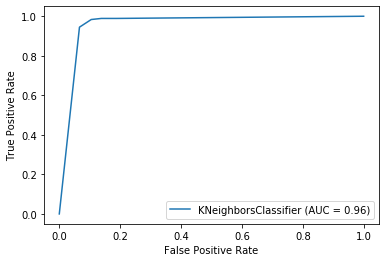

In [154]:
np.random.seed(7)
knn = KNeighborsClassifier(n_neighbors =4)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

cr_knn=classification_report(y_test,y_pred)
cm_knn=confusion_matrix(y_test,y_pred)
a_knn=accuracy_score(y_test,y_pred)*100
p_knn=precision_score(y_test,y_pred)*100
r_knn=recall_score(y_test,y_pred)*100
f_knn=f1_score(y_test,y_pred)*100
knn_scores=[a_knn,p_knn,r_knn,f_knn]

print ("Classification report:")
print(cr_knn)
print ("Confusion matrix:")
print (cm_knn)
print ("Accuracy score: ",a_knn)
print ("Precision score: ",p_knn)
print ("Recall score: ",r_knn)
print ("F1 score: ",f_knn)
print ("\nTime: ",knn_fit_time)
print ("ROC curve:")
plot_roc_curve(knn,X_test, y_test);

### 8.5.6. Support Vector Machine 
Here we will be using GridSearchCV which tries every single combination of hyperparameters and saves the best model.
It also includes cross-validation. <br>
Normalized data should be used for support vector machine. But we tried it and it gave us worse results.

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.502, total=   0.5s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.498, total=   0.4s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.498, total=   0.4s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.498, total=   0.3s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.517, total=   0.3s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ...... C=0.1, gamma=1, kernel=sigmoid, score=0.498, total=   0.2s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ...... C=0.1, gamma=1, kernel=sigmoid, score=0.498, total=   0.2s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ...... C=0.1, gamma=1, kernel=sigmoid, score=0.498, total=   0.1s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ...... C=0.1, gamma=1, kernel=sigmoid, score=0.498, total=   0.1s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] .

[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.761, total=   0.3s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.744, total=   0.3s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.785, total=   0.3s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.785, total=   0.3s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.781, total=   0.3s
[CV] C=1, gamma=0.1, kernel=sigmoid ..................................
[CV] ...... C=1, gamma=0.1, kernel=sigmoid, score=0.498, total=   0.0s
[CV] C=1, gamma=0.1, kernel=sigmoid ..................................
[CV] ...... C=1, gamma=0.1, kernel=sigmoid, score=0.498, total=   0.1s
[CV] C=1, gamma=0.1, kernel=sigmoid ..................................
[CV] .

[CV] ..... C=10, gamma=0.1, kernel=sigmoid, score=0.498, total=   0.1s
[CV] C=10, gamma=0.1, kernel=sigmoid .................................
[CV] ..... C=10, gamma=0.1, kernel=sigmoid, score=0.500, total=   0.1s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.920, total=   0.3s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.896, total=   0.2s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.952, total=   0.2s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.952, total=   0.2s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.951, total=   0.2s
[CV] C=10, gamma=0.01, kernel=sigmoid ................................
[CV] .

[CV] ... C=100, gamma=0.01, kernel=sigmoid, score=0.498, total=   0.1s
[CV] C=100, gamma=0.01, kernel=sigmoid ...............................
[CV] ... C=100, gamma=0.01, kernel=sigmoid, score=0.498, total=   0.1s
[CV] C=100, gamma=0.01, kernel=sigmoid ...............................
[CV] ... C=100, gamma=0.01, kernel=sigmoid, score=0.500, total=   0.0s
[CV] C=100, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=100, gamma=0.001, kernel=rbf, score=0.972, total=   0.0s
[CV] C=100, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=100, gamma=0.001, kernel=rbf, score=0.952, total=   0.1s
[CV] C=100, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=100, gamma=0.001, kernel=rbf, score=0.965, total=   0.1s
[CV] C=100, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=100, gamma=0.001, kernel=rbf, score=0.958, total=   0.0s
[CV] C=100, gamma=0.001, kernel=rbf ..................................
[CV] .

[CV] . C=1000, gamma=0.001, kernel=sigmoid, score=0.498, total=   0.1s
[CV] C=1000, gamma=0.001, kernel=sigmoid .............................
[CV] . C=1000, gamma=0.001, kernel=sigmoid, score=0.498, total=   0.1s
[CV] C=1000, gamma=0.001, kernel=sigmoid .............................
[CV] . C=1000, gamma=0.001, kernel=sigmoid, score=0.486, total=   0.1s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.962, total=   0.2s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.945, total=   0.2s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.958, total=   0.2s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.958, total=   0.2s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV] .

[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:   36.8s finished


Best parameters found:
 {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
Classification report:
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       181
           1       0.94      0.98      0.96       181

    accuracy                           0.96       362
   macro avg       0.96      0.96      0.96       362
weighted avg       0.96      0.96      0.96       362

Confusion matrix:
[[170  11]
 [  4 177]]
Accuracy score:  95.85635359116023
Precision score:  94.14893617021278
Recall score:  97.79005524861878
F1 score:  95.9349593495935

Time:  37.030766248703
ROC curve:


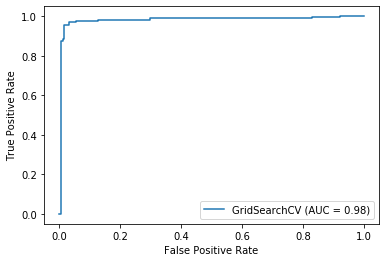

In [155]:
np.random.seed(7)
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf','sigmoid']}  
  
svc = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3);
start_time = time.time()
svc.fit(X_train, y_train);
y_pred = svc.predict(X_test)
finish_time = time.time()
ssvc_fit_time = finish_time-start_time
print('Best parameters found:\n', svc.best_params_)

cr_ssvc=classification_report(y_test,y_pred)
cm_ssvc=confusion_matrix(y_test,y_pred)
a_ssvc=accuracy_score(y_test,y_pred)*100
p_ssvc=precision_score(y_test,y_pred)*100
r_ssvc=recall_score(y_test,y_pred)*100
f_ssvc=f1_score(y_test,y_pred)*100
ssvc_scores=[a_ssvc,p_ssvc,r_ssvc,f_ssvc]

print ("Classification report:")
print(cr_ssvc)
print ("Confusion matrix:")
print (cm_ssvc)
print ("Accuracy score: ",a_ssvc)
print ("Precision score: ",p_ssvc)
print ("Recall score: ",r_ssvc)
print ("F1 score: ",f_ssvc)
print ("\nTime: ",ssvc_fit_time)
print ("ROC curve:")
plot_roc_curve(svc,X_test, y_test);

Comparison to the previous, simpler Support Vector Classifiers:

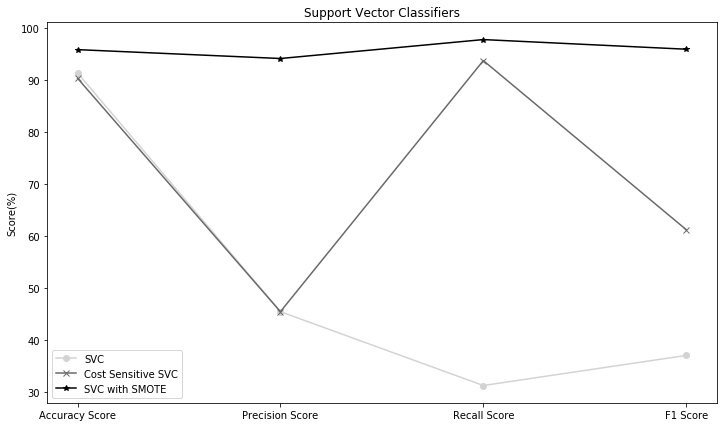

In [159]:
plt.figure(figsize=(12,7))
plt.title("Support Vector Classifiers")
plt.ylabel("Score(%)")
plt.plot(svc_scores, marker="o", label="SVC",color='lightgray')
plt.plot(csvc_scores, marker="x", label="Cost Sensitive SVC",color='dimgray')
plt.plot(ssvc_scores, marker="*", label="SVC with SMOTE",color='black')

ax = plt.gca()
ax.set_xticks(np.arange(4))
ax.set_xticklabels([ "Accuracy Score","Precision Score", "Recall Score","F1 Score"])
plt.legend()
plt.show()

### 8.5.7. Artificial Neural Networks
Once again we are using GridSearchCV to find the best parameters. For the hidden layers sizes we are trying every combination with one, two and three hidden layers, each with 6 to 12 neurons.

In [82]:
#this will be needed for the hidden layers size
l=[]
for i in range (6,13):
    t=(i)
    l.append(t)
    for j in range (6,13):
        t2=(i,j)
        l.append(t2)
        for k in  range (6,13):
            t3=(i,j,k)
            l.append(t3)

Best parameters found:
 {'alpha': 0.05, 'hidden_layer_sizes': (12, 12, 11), 'learning_rate': 'adaptive'}
Classification report:
              precision    recall  f1-score   support

           0       0.97      0.80      0.88       181
           1       0.83      0.98      0.90       181

    accuracy                           0.89       362
   macro avg       0.90      0.89      0.89       362
weighted avg       0.90      0.89      0.89       362

Confusion matrix:
[[144  37]
 [  4 177]]
Accuracy score:  88.67403314917127
Precision score:  82.71028037383178
Recall score:  97.79005524861878
F1 score:  89.62025316455696

Time:  6583.451677560806
ROC curve:


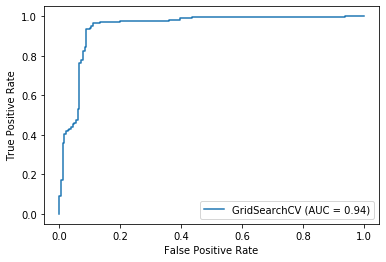

In [83]:
#Normalized
np.random.seed(7)
parameter_space = {'hidden_layer_sizes': l,'alpha': [0.0001, 0.05],'learning_rate': ['constant','adaptive']}
mlp = GridSearchCV(MLPClassifier(max_iter=100), parameter_space,refit = True, n_jobs=-1, cv=5)
start_time = time.time()
mlp.fit(Xn_train, y_train)
y_pred = mlp.predict(Xn_test)
finish_time = time.time()
mlp_fit_time = finish_time-start_time

cr_mlp=classification_report(y_test,y_pred)
cm_mlp=confusion_matrix(y_test,y_pred)
a_mlp=accuracy_score(y_test,y_pred)*100
p_mlp=precision_score(y_test,y_pred)*100
r_mlp=recall_score(y_test,y_pred)*100
f_mlp=f1_score(y_test,y_pred)*100
mlp_scores=[a_mlp,p_mlp,r_mlp,f_mlp]

print('Best parameters found:\n', mlp.best_params_)
print ("Classification report:")
print(cr_mlp)
print ("Confusion matrix:")
print (cm_mlp)
print ("Accuracy score: ",a_mlp)
print ("Precision score: ",p_mlp)
print ("Recall score: ",r_mlp)
print ("F1 score: ",f_mlp)
print ("\nTime: ",mlp_fit_time)
print ("ROC curve:")
plot_roc_curve(mlp,Xn_test, y_test);

## 8.6. Ensemble Algorithms for Classification
The following ensamble methods for classsification are also using the oversampled dataset. We will be using: Bagged Decision Trees, Random forest, AdaBoost with Decision Tree Classifier, AdaBoost with SVC, Gradient Boosting Classifier and XGB.

### 8.6.1. Bagged Decision Trees
This ensamle model is using 15 estimators - Decision Tree Classifiers with maximum depth 11 and gini index as a measure for a quality of a split.

Classification report:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       181
           1       0.92      0.96      0.94       181

    accuracy                           0.94       362
   macro avg       0.94      0.94      0.94       362
weighted avg       0.94      0.94      0.94       362

Confusion matrix:
[[166  15]
 [  7 174]]
Accuracy score:  93.92265193370166
Precision score:  92.06349206349206
Recall score:  96.13259668508287
F1 score:  94.05405405405406

Time:  0.24401402473449707
ROC curve:


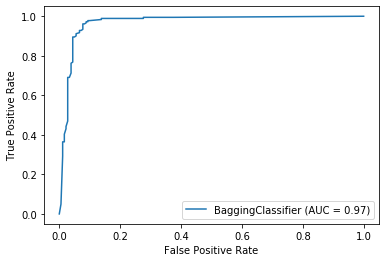

In [181]:
np.random.seed(7)
bagged_decision_tree = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=11),n_estimators=15, random_state=0)
start_time=time.time()
bagged_decision_tree.fit(X_train, y_train)
y_pred = bagged_decision_tree.predict(X_test)
finish_time = time.time()
bdt_fit_time = finish_time-start_time

cr_bdt=classification_report(y_test,y_pred)
cm_bdt=confusion_matrix(y_test,y_pred)
a_bdt=accuracy_score(y_test,y_pred)*100
p_bdt=precision_score(y_test,y_pred)*100
r_bdt=recall_score(y_test,y_pred)*100
f_bdt=f1_score(y_test,y_pred)*100
bdt_scores=[a_bdt,p_bdt,r_bdt,f_bdt]

print ("Classification report:")
print(cr_bdt)
print ("Confusion matrix:")
print (cm_bdt)
print ("Accuracy score: ",a_bdt)
print ("Precision score: ",p_bdt)
print ("Recall score: ",r_bdt)
print ("F1 score: ",f_bdt)
print ("\nTime: ",bdt_fit_time)
print ("ROC curve:")
plot_roc_curve(bagged_decision_tree,X_test, y_test);

### 8.6.2. Bagged SVC
This ensamle model is using 15 estimators - SVC with RBF kernels.

Classification report:
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       181
           1       0.94      0.98      0.96       181

    accuracy                           0.96       362
   macro avg       0.96      0.96      0.96       362
weighted avg       0.96      0.96      0.96       362

Confusion matrix:
[[170  11]
 [  4 177]]
Accuracy score:  95.85635359116023
Precision score:  94.14893617021278
Recall score:  97.79005524861878
F1 score:  95.9349593495935

Time:  0.6490373611450195
ROC curve:


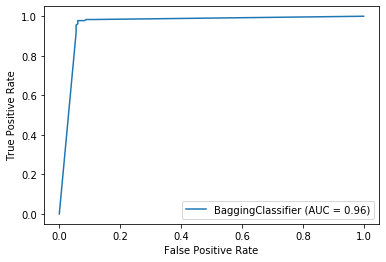

In [182]:
np.random.seed(7)
bagged_svc = BaggingClassifier(base_estimator=SVC(gamma= 0.001),n_estimators=15, random_state=0)
start_time=time.time()
bagged_svc.fit(X_train, y_train)
y_pred = bagged_svc.predict(X_test)
finish_time = time.time()
bagsvc_fit_time = finish_time-start_time

cr_bagsvc=classification_report(y_test,y_pred)
cm_bagsvc=confusion_matrix(y_test,y_pred)
a_bagsvc=accuracy_score(y_test,y_pred)*100
p_bagsvc=precision_score(y_test,y_pred)*100
r_bagsvc=recall_score(y_test,y_pred)*100
f_bagsvc=f1_score(y_test,y_pred)*100
bagsvc_scores=[a_bagsvc,p_bagsvc,r_bagsvc,f_bagsvc]

print ("Classification report:")
print(cr_bagsvc)
print ("Confusion matrix:")
print (cm_bagsvc)
print ("Accuracy score: ",a_bagsvc)
print ("Precision score: ",p_bagsvc)
print ("Recall score: ",r_bagsvc)
print ("F1 score: ",f_bagsvc)
print ("\nTime: ",bagsvc_fit_time)
print ("ROC curve:")
plot_roc_curve(bagged_svc,X_test, y_test);

### 8.6.3. Random Forest Classifier
This model uses 20 basic classifiers.

Classification report:
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       181
           1       0.94      0.97      0.95       181

    accuracy                           0.95       362
   macro avg       0.95      0.95      0.95       362
weighted avg       0.95      0.95      0.95       362

Confusion matrix:
[[169  12]
 [  5 176]]
Accuracy score:  95.30386740331491
Precision score:  93.61702127659575
Recall score:  97.23756906077348
F1 score:  95.39295392953929

Time:  0.13600778579711914
ROC curve:


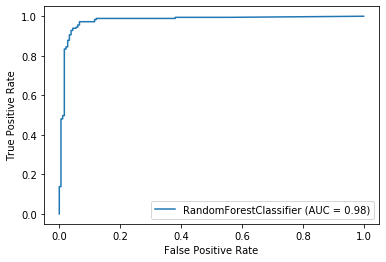

In [164]:
np.random.seed(7)
random_forest = RandomForestClassifier(max_depth=10, random_state=0,n_estimators=20)
start_time = time.time()
random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)
finish_time = time.time()
srf_fit_time = finish_time-start_time

cr_srf=classification_report(y_test,y_pred)
cm_srf=confusion_matrix(y_test,y_pred)
a_srf=accuracy_score(y_test,y_pred)*100
p_srf=precision_score(y_test,y_pred)*100
r_srf=recall_score(y_test,y_pred)*100
f_srf=f1_score(y_test,y_pred)*100
srf_scores=[a_srf,p_srf,r_srf,f_srf]

print ("Classification report:")
print(cr_srf)
print ("Confusion matrix:")
print (cm_srf)
print ("Accuracy score: ",a_srf)
print ("Precision score: ",p_srf)
print ("Recall score: ",r_srf)
print ("F1 score: ",f_srf)
print ("\nTime: ",srf_fit_time)
print ("ROC curve:")
plot_roc_curve(random_forest,X_test, y_test);

Comparison to the previous, simpler Random Forest Classifiers:

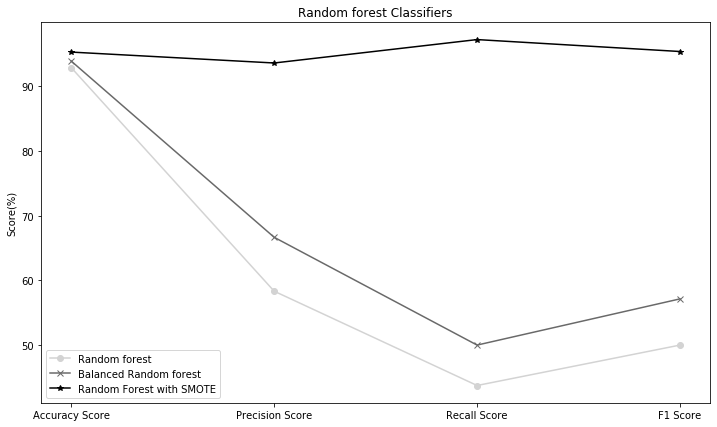

In [165]:
plt.figure(figsize=(12,7))
plt.title("Random forest Classifiers")
plt.ylabel("Score(%)")
plt.plot(rf_scores, marker="o", label="Random forest",color='lightgray')
plt.plot(crf_scores, marker="x", label="Balanced Random forest",color='dimgray')
plt.plot(srf_scores, marker="*", label="Random Forest with SMOTE",color='black')

ax = plt.gca()
ax.set_xticks(np.arange(4))
ax.set_xticklabels([ "Accuracy Score","Precision Score", "Recall Score","F1 Score"])
plt.legend()
plt.show()

### 8.6.4. AdaBoost with Decision Tree Classifier
We will use hyperparameter tuning for the number of estimators.

Maximum AdaBoost accuracy score on the test data:  95.30386740331491  at number of estimators:  12
Maximum AdaBoost f1 score on the test data:  95.4177897574124  at number of estimators:  12


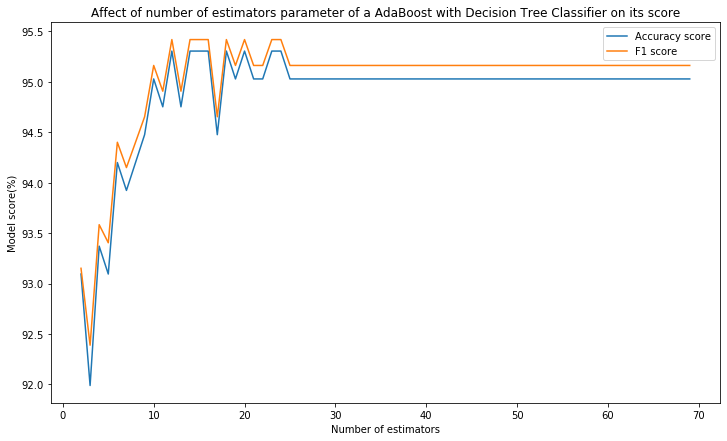

In [166]:
accuracy_scores = []
f1_scores = []

num_estimators = range(2, 70)
abc = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=11),learning_rate=1)
start_time=time.time()
for i in num_estimators:
    np.random.seed(7)
    abc.set_params(n_estimators=i)
    abc.fit(X_train, y_train)
    y_pred=abc.predict(X_test)    
    accuracy_scores.append(accuracy_score(y_test,y_pred)*100)
    f1_scores.append(f1_score(y_test,y_pred)*100)
finish_time = time.time()
abc_fit_time = finish_time-start_time
    
plt.figure(figsize=(12,7))
plt.title("Affect of number of estimators parameter of a AdaBoost with Decision Tree Classifier on its score")
plt.plot(num_estimators,accuracy_scores , label="Accuracy score")
plt.plot(num_estimators, f1_scores, label="F1 score")
plt.xlabel("Number of estimators")
plt.ylabel("Model score(%)")
plt.legend();

print("Maximum AdaBoost accuracy score on the test data: ",max(accuracy_scores)," at number of estimators: ",np.argmax(accuracy_scores)+2)
print("Maximum AdaBoost f1 score on the test data: ",max(f1_scores)," at number of estimators: ",np.argmax(f1_scores)+2)

We found out that the best AdaBoost with Decision Tree Classifier has 12 estimators. We will construct it once again, to save the scores for later comparison with other classifiers.

Classification report:
              precision    recall  f1-score   support

           0       0.98      0.93      0.95       181
           1       0.93      0.98      0.95       181

    accuracy                           0.95       362
   macro avg       0.95      0.95      0.95       362
weighted avg       0.95      0.95      0.95       362

Confusion matrix:
[[168  13]
 [  4 177]]
Accuracy score:  95.30386740331491
Precision score:  93.15789473684211
Recall score:  97.79005524861878
F1 score:  95.4177897574124

Time:  26.812525033950806
ROC curve:


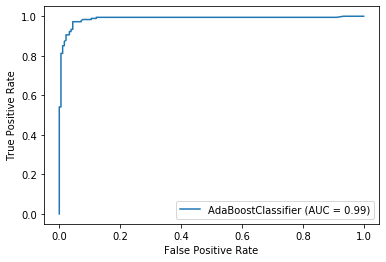

In [167]:
np.random.seed(7)
abc = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=11),learning_rate=1,n_estimators=12)
abc.fit(X_train, y_train);
y_pred = abc.predict(X_test)

cr_abc=classification_report(y_test,y_pred)
cm_abc=confusion_matrix(y_test,y_pred)
a_abc=accuracy_score(y_test,y_pred)*100
p_abc=precision_score(y_test,y_pred)*100
r_abc=recall_score(y_test,y_pred)*100
f_abc=f1_score(y_test,y_pred)*100
abc_scores=[a_abc,p_abc,r_abc,f_abc]

print ("Classification report:")
print(cr_abc)
print ("Confusion matrix:")
print (cm_abc)
print ("Accuracy score: ",a_abc)
print ("Precision score: ",p_abc)
print ("Recall score: ",r_abc)
print ("F1 score: ",f_abc)
print ("\nTime: ",abc_fit_time)
print ("ROC curve:")
plot_roc_curve(abc,X_test, y_test);

### 8.6.5. AdaBoost with SVC
We will use hyperparameter tuning for the number of estimators.

Maximum AdaBoost accuracy score on the test data:  86.74033149171271  at number of estimators:  4
Maximum AdaBoost f1 score on the test data:  88.05970149253733  at number of estimators:  4


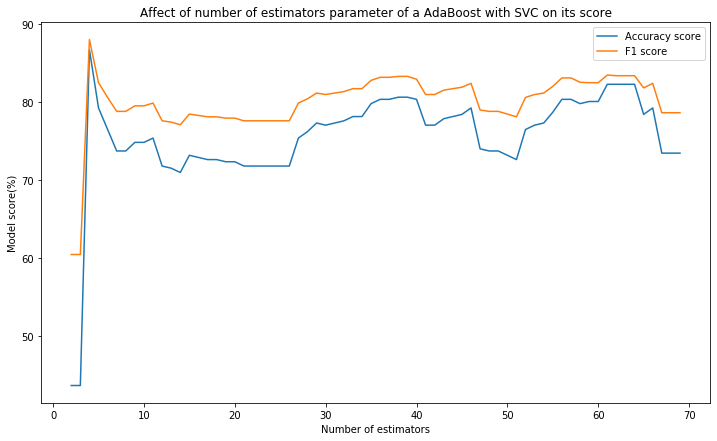

In [189]:
accuracy_scores = []
f1_scores = []

num_estimators = range(2, 70)
abc = AdaBoostClassifier(base_estimator=SVC(probability=True,gamma= 0.001),learning_rate=1)
start_time=time.time()
for i in num_estimators:
    np.random.seed(7)
    abc.set_params(n_estimators=i)
    abc.fit(X_train, y_train)
    y_pred=abc.predict(X_test)    
    accuracy_scores.append(accuracy_score(y_test,y_pred)*100)
    f1_scores.append(f1_score(y_test,y_pred)*100)
finish_time = time.time()
abcs_fit_time = finish_time-start_time

plt.figure(figsize=(12,7))
plt.title("Affect of number of estimators parameter of a AdaBoost with SVC on its score")
plt.plot(num_estimators,accuracy_scores , label="Accuracy score")
plt.plot(num_estimators, f1_scores, label="F1 score")
plt.xlabel("Number of estimators")
plt.ylabel("Model score(%)")
plt.legend();

print("Maximum AdaBoost accuracy score on the test data: ",max(accuracy_scores)," at number of estimators: ",np.argmax(accuracy_scores)+2)
print("Maximum AdaBoost f1 score on the test data: ",max(f1_scores)," at number of estimators: ",np.argmax(f1_scores)+2)

We found out that the best AdaBoost with SVC has 4 estimators. We will construct it once again, to save the scores for later comparison with other classifiers.

Classification report:
              precision    recall  f1-score   support

           0       0.97      0.76      0.85       181
           1       0.80      0.98      0.88       181

    accuracy                           0.87       362
   macro avg       0.89      0.87      0.87       362
weighted avg       0.89      0.87      0.87       362

Confusion matrix:
[[137  44]
 [  4 177]]
Accuracy score:  86.74033149171271
Precision score:  80.09049773755656
Recall score:  97.79005524861878
F1 score:  88.05970149253733

Time:  1843.7766525745392
ROC curve:


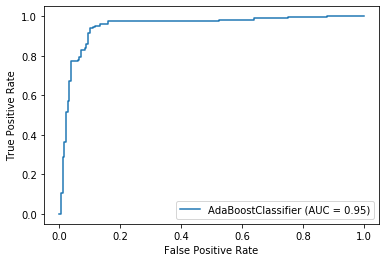

In [191]:
np.random.seed(7)
abc = AdaBoostClassifier(base_estimator=SVC(probability=True,gamma= 0.001),learning_rate=1,n_estimators=4)
abc.fit(X_train, y_train);
y_pred = abc.predict(X_test)

cr_abcs=classification_report(y_test,y_pred)
cm_abcs=confusion_matrix(y_test,y_pred)
a_abcs=accuracy_score(y_test,y_pred)*100
p_abcs=precision_score(y_test,y_pred)*100
r_abcs=recall_score(y_test,y_pred)*100
f_abcs=f1_score(y_test,y_pred)*100
abcs_scores=[a_abcs,p_abcs,r_abcs,f_abcs]

print ("Classification report:")
print(cr_abcs)
print ("Confusion matrix:")
print (cm_abcs)
print ("Accuracy score: ",a_abcs)
print ("Precision score: ",p_abcs)
print ("Recall score: ",r_abcs)
print ("F1 score: ",f_abcs)
print ("\nTime: ",abcs_fit_time)
print ("ROC curve:")
plot_roc_curve(abc,X_test, y_test);

### 8.6.6. Gradient Boosting Classifier
We will use hyperparameter tuning for the number of estimators and the learning rate.

Best parameters found:
 {'learning_rate': 1, 'n_estimators': 110}
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.91      0.93       181
           1       0.92      0.96      0.94       181

    accuracy                           0.94       362
   macro avg       0.94      0.94      0.94       362
weighted avg       0.94      0.94      0.94       362

Confusion matrix:
[[165  16]
 [  7 174]]
Accuracy score:  93.646408839779
Precision score:  91.57894736842105
Recall score:  96.13259668508287
F1 score:  93.80053908355795

Time:  56.992807149887085
ROC curve:


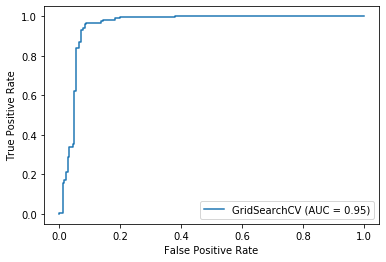

In [87]:
np.random.seed(7)
param_grid = {'n_estimators': [10,20,30,40,50,60,70,80,90,100,110],  
              'learning_rate': [1, 0.1, 0.01, 0.001, 0.0001]}  
  
gbc = GridSearchCV(GradientBoostingClassifier(),param_grid,refit = True,cv=5)
start_time=time.time()
gbc.fit(X_train, y_train)
y_pred = gbc.predict(X_test)
finish_time = time.time()
gbc_fit_time = finish_time-start_time

cr_gbc=classification_report(y_test,y_pred)
cm_gbc=confusion_matrix(y_test,y_pred)
a_gbc=accuracy_score(y_test,y_pred)*100
p_gbc=precision_score(y_test,y_pred)*100
r_gbc=recall_score(y_test,y_pred)*100
f_gbc=f1_score(y_test,y_pred)*100
gbc_scores=[a_gbc,p_gbc,r_gbc,f_gbc]

print('Best parameters found:\n', gbc.best_params_)
print ("Classification report:")
print(cr_gbc)
print ("Confusion matrix:")
print (cm_gbc)
print ("Accuracy score: ",a_gbc)
print ("Precision score: ",p_gbc)
print ("Recall score: ",r_gbc)
print ("F1 score: ",f_gbc)
print ("\nTime: ",gbc_fit_time)
print ("ROC curve:")
plot_roc_curve(gbc,X_test, y_test);

### 8.6.7. XGBoost
We will use hyperparameter tuning.

Best parameters found:
 {'colsample_bytree': 1, 'gamma': 0.0, 'max_depth': 10, 'n_estimators': 80}
Classification report:
              precision    recall  f1-score   support

           0       0.97      0.92      0.94       181
           1       0.92      0.97      0.95       181

    accuracy                           0.94       362
   macro avg       0.95      0.94      0.94       362
weighted avg       0.95      0.94      0.94       362

Confusion matrix:
[[166  15]
 [  5 176]]
Accuracy score:  94.47513812154696
Precision score:  92.14659685863874
Recall score:  97.23756906077348
F1 score:  94.6236559139785

Time:  653.7910959720612
ROC curve:


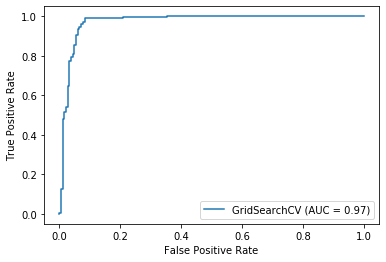

In [88]:
np.random.seed(7)
param_grid = {'n_estimators': [80,90,100,110],  'max_depth':[8,9,10,11],"gamma" : [ 0.0, 0.1 ],"colsample_bytree" : [ 0.5 , 1]}    
  
xgb = GridSearchCV(XGBClassifier(),param_grid,refit = True,cv=5)
start_time=time.time()
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
finish_time = time.time()
xgb_fit_time = finish_time-start_time

cr_xgb=classification_report(y_test,y_pred)
cm_xgb=confusion_matrix(y_test,y_pred)
a_xgb=accuracy_score(y_test,y_pred)*100
p_xgb=precision_score(y_test,y_pred)*100
r_xgb=recall_score(y_test,y_pred)*100
f_xgb=f1_score(y_test,y_pred)*100
xgb_scores=[a_xgb,p_xgb,r_xgb,f_xgb]

print('Best parameters found:\n', xgb.best_params_)
print ("Classification report:")
print(cr_xgb)
print ("Confusion matrix:")
print (cm_xgb)
print ("Accuracy score: ",a_xgb)
print ("Precision score: ",p_xgb)
print ("Recall score: ",r_xgb)
print ("F1 score: ",f_xgb)
print ("\nTime: ",xgb_fit_time)
print ("ROC curve:")
plot_roc_curve(xgb,X_test, y_test);

# 9. Models Comparison
### Which model gives best results?

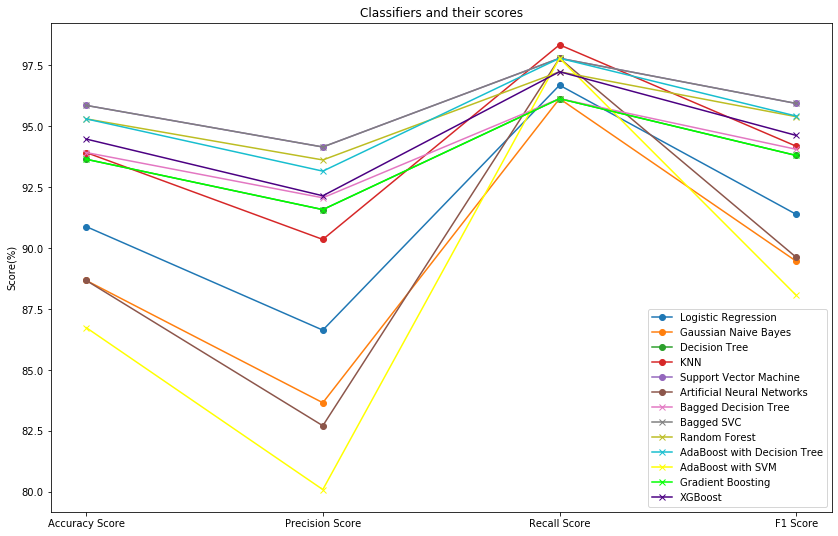

In [192]:
plt.figure(figsize=(14,9))
plt.ylabel("Score(%)")
plt.title("Classifiers and their scores")
plt.plot(slr_scores, marker="o", label="Logistic Regression")
plt.plot(gnb_scores, marker="o", label="Gaussian Naive Bayes")
plt.plot(sdt_scores, marker="o", label="Decision Tree")
plt.plot(knn_scores, marker="o", label="KNN")
plt.plot(ssvc_scores, marker="o", label="Support Vector Machine")
plt.plot(mlp_scores, marker="o", label="Artificial Neural Networks")
# Ensemble Algorithms for Classification
plt.plot(bdt_scores, marker="x", label="Bagged Decision Tree")
plt.plot(bagsvc_scores, marker="x", label="Bagged SVC")
plt.plot(srf_scores, marker="x", label="Random Forest")
plt.plot(abc_scores, marker="x", label="AdaBoost with Decision Tree")
plt.plot(abcs_scores, marker="x", label="AdaBoost with SVM",color='yellow')
plt.plot(gbc_scores, marker="x", label="Gradient Boosting",color='lime')
plt.plot(xgb_scores, marker="x", label="XGBoost",color='indigo')

ax = plt.gca()
ax.set_xticks(np.arange(4))
ax.set_xticklabels([ "Accuracy Score","Precision Score", "Recall Score","F1 Score"])
plt.legend()
plt.show()

In [169]:
r_knn-r_ssvc

0.5524861878453038

From the graph above we can conclude that the Support Vector Machine with RBF kernel is the best classifier. The ensamble method that uses bagging technique with 15 of those classifiers gives the same results. It outperforms all other classifiers in every score, except the recall. KNN has the highest recall score, but SVM comes second with only 0.55% lower score.

In [170]:
print ("The SVM scores are:")
print ("Accuracy score: ",a_ssvc)
print ("Precision score: ",p_ssvc)
print ("Recall score: ",r_ssvc)
print ("F1 score: ",f_ssvc)
print ("\nConfusion matrix:")
print (cm_ssvc)

The SVM scores are:
Accuracy score:  95.85635359116023
Precision score:  94.14893617021278
Recall score:  97.79005524861878
F1 score:  95.9349593495935

Confusion matrix:
[[170  11]
 [  4 177]]


In [171]:
print ("And the highest recall score (gotten with KNN classification) is:",r_knn)

And the highest recall score (gotten with KNN classification) is: 98.34254143646409


In [172]:
print ("Gaussian Naive Bayes recall score: ",r_gnb)

Gaussian Naive Bayes recall score:  96.13259668508287


Also, every classifier we used after applying the SMOTE technique has very high recall score - all above 96%.

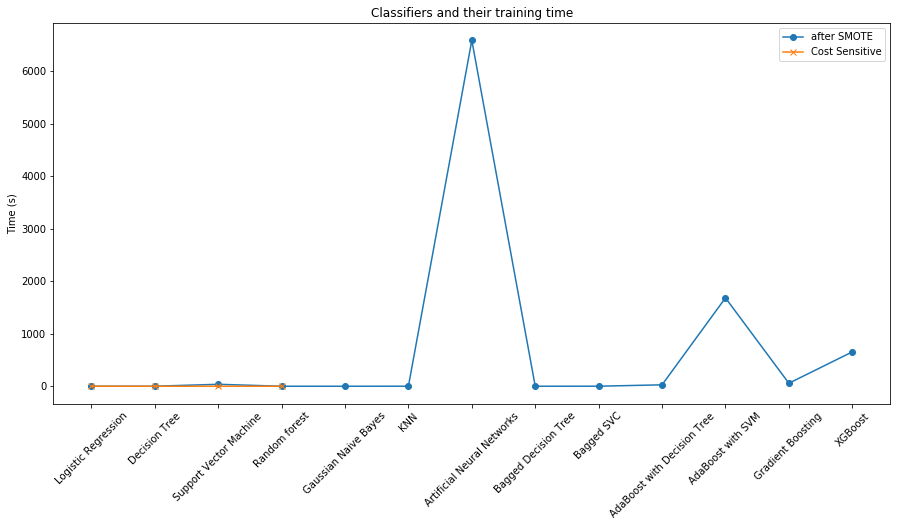

In [188]:
plt.figure(figsize=(15,7))
plt.ylabel("Time (s)")
plt.title("Classifiers and their training time")
plt.plot([slr_fit_time, sdt_fit_time, ssvc_fit_time, srf_fit_time,\
         gnb_fit_time, knn_fit_time, mlp_fit_time, bdt_fit_time,bagsvc_fit_time,\
         abc_fit_time, abcs_fit_time, gbc_fit_time, xgb_fit_time], marker="o",label="after SMOTE")
plt.plot([clr_fit_time, cdt_fit_time,csvc_fit_time, crf_fit_time], marker="x",label="Cost Sensitive")
ax = plt.gca()
ax.set_xticks(np.arange(13))
ax.set_xticklabels(["Logistic Regression", "Decision Tree","Support Vector Machine", "Random forest",\
                    "Gaussian Naive Bayes","KNN","Artificial Neural Networks","Bagged Decision Tree","Bagged SVC",\
                    "AdaBoost with Decision Tree","AdaBoost with SVM","Gradient Boosting","XGBoost"], rotation=45)
plt.legend()
plt.show()

Artificial Neural Networks, AdaBoost with SVM and XGBoost required much more time than the other classifiers. That is due to the hyperparameter tuning.